In [1]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

try:
    # %tensorflow_version only exists in Colab.
    %tensorflow_version 2.x
except Exception:
    pass

# TensorFlow ≥2.0 is required
import tensorflow as tf
from tensorflow import keras
assert tf.__version__ >= "2.0"

%load_ext tensorboard

# Common imports
import numpy as np
import os

# to make this notebook's output stable across runs
np.random.seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)


import keras_tuner as kt
import pandas as pd

import warnings
warnings.filterwarnings('ignore')

2023-01-11 12:14:56.016094: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0


In [2]:
tf.random.set_seed(42)
np.random.seed(42)

# Deep Learning

Import MNIST dataset 

In [3]:
(X_train_full,y_train_full),(X_test,y_test)=keras.datasets.mnist.load_data()

11493376/11490434 [==============================] - 0s 0us/step


Check the data shape and plot the image of the dataset

In [4]:
print("Training data size: ",X_train_full.shape)
print("Testing data size: ",X_test.shape)


Training data size:  (60000, 28, 28)
Testing data size:  (10000, 28, 28)


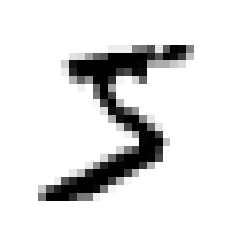

In [5]:
plt.imshow(X_train_full[0],cmap='binary')
plt.axis('off')
plt.show()

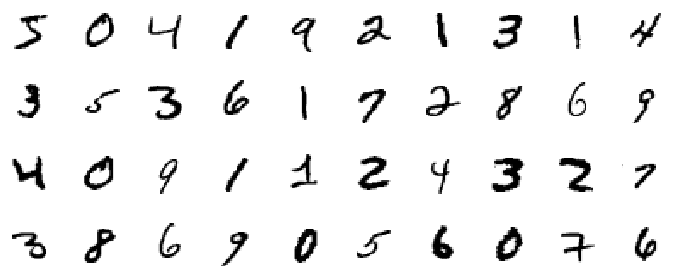

In [6]:
n_rows = 4
n_cols = 10
plt.figure(figsize=(n_cols * 1.2, n_rows * 1.2))
for row in range(n_rows):
    for col in range(n_cols):
        index = n_cols * row + col
        plt.subplot(n_rows, n_cols, index + 1)
        plt.imshow(X_train_full[index], cmap="binary", interpolation="nearest")
        plt.axis('off')
plt.subplots_adjust(wspace=0.2, hspace=0.5)
plt.show()

Split the full training set into a validation set (20% of the training dataset) and a training set. Then Scale the pixel intensities down to the 0-1 range and convert them to floats, by dividing by 255.

In [7]:
X_train_full.shape[0]

60000

In [8]:
X_valid,X_train=X_train_full[:int(X_train_full.shape[0]*0.2)]/255.,X_train_full[int(X_train_full.shape[0]*0.2):]/255.0
y_valid,y_train=y_train_full[:int(y_train_full.shape[0]*0.2)],y_train_full[int(y_train_full.shape[0]*0.2):]
X_test=X_test/255.

In [9]:
print("Training data size: ",X_train.shape)
print("Validation data size: ",X_valid.shape)

Training data size:  (48000, 28, 28)
Validation data size:  (12000, 28, 28)


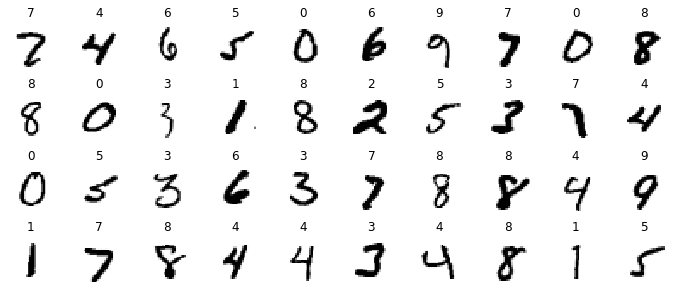

In [10]:
n_rows = 4
n_cols = 10
plt.figure(figsize=(n_cols * 1.2, n_rows * 1.2))
for row in range(n_rows):
    for col in range(n_cols):
        index = n_cols * row + col
        plt.subplot(n_rows, n_cols, index + 1)
        plt.imshow(X_train[index], cmap="binary", interpolation="nearest")
        plt.axis('off')
        plt.title(y_train[index], fontsize=12)
plt.subplots_adjust(wspace=0.2, hspace=0.5)
plt.show()

Let's split the fashion MNIST training set in two:
- X_train_A : All images of digits 0 to 4
- X_train_B : All images of digits 5 to 9 (use transfer learning in further)

In [11]:
def split_dataset(X,y):
    # Select the digit from 0 to 4
    y_0_to_4=(y==0)  | (y == 1)  | (y == 2)  | (y == 3)  | (y == 4)
    
    # Inverse the y_0_to_4 to get the digits from 5 to 9
    y_5_to_9=y[~y_0_to_4]
    
    return ((X[y_0_to_4],y[y_0_to_4]),(X[y_5_to_9],y_5_to_9))

In [12]:
(X_train_A, y_train_A), (X_train_B, y_train_B) = split_dataset(X_train, y_train)
(X_valid_A, y_valid_A), (X_valid_B, y_valid_B) = split_dataset(X_valid, y_valid)
(X_test_A, y_test_A), (X_test_B, y_test_B) = split_dataset(X_test, y_test)

In [13]:
X_train_A.shape

(24451, 28, 28)

In [14]:
X_train_B.shape

(23549, 28, 28)

In [15]:
y_train_A[:30]

array([4, 0, 0, 0, 3, 1, 2, 3, 4, 0, 3, 3, 4, 1, 4, 4, 3, 4, 1, 1, 1, 1,
       3, 1, 4, 2, 4, 1, 0, 4], dtype=uint8)

In [16]:
y_train_B[:30]

array([7, 6, 5, 6, 9, 7, 8, 8, 8, 5, 7, 5, 6, 7, 8, 8, 9, 7, 8, 8, 5, 8,
       8, 5, 6, 7, 9, 9, 8, 9], dtype=uint8)

In [17]:
X_test_A.shape

(5139, 28, 28)

In [18]:
X_test_B.shape

(4861, 28, 28)

In [19]:
y_test_A[:30]

array([2, 1, 0, 4, 1, 4, 0, 0, 1, 3, 4, 4, 0, 4, 0, 1, 3, 1, 3, 4, 2, 1,
       2, 1, 1, 4, 2, 3, 1, 2], dtype=uint8)

In [20]:
y_test_B[:30]

array([7, 9, 5, 9, 6, 9, 5, 9, 7, 9, 6, 6, 5, 7, 7, 7, 7, 5, 6, 5, 5, 6,
       9, 5, 7, 8, 9, 7, 6, 7], dtype=uint8)

In [21]:
evaluation = pd.DataFrame({'Model': [],
                           'Loss':[],
                           "Accuracy":[],
                           'Epochs':[]
                           })

Build a DNN with five hidden layers of 100 neurons each, He initialization,
and the ELU activation function.

In [22]:
model=keras.models.Sequential()
model.add(keras.layers.Flatten(input_shape=[28,28]))
for _ in range(5):
    model.add(keras.layers.Dense(100,activation='elu',kernel_initializer='he_normal'))
    

2023-01-11 12:15:12.856194: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2023-01-11 12:15:12.861713: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2023-01-11 12:15:12.978543: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:941] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-11 12:15:12.979369: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:00:04.0 name: Tesla T4 computeCapability: 7.5
coreClock: 1.59GHz coreCount: 40 deviceMemorySize: 14.75GiB deviceMemoryBandwidth: 298.08GiB/s
2023-01-11 12:15:12.979547: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:941] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-1

Add the softmax output layer to the model.</br>
Since we just need to classifier the digits from 0 to 4 therefore I just add the 5 neurons to the output layer

In [23]:
model.add(keras.layers.Dense(5,activation='softmax'))

In [24]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 784)               0         
_________________________________________________________________
dense (Dense)                (None, 100)               78500     
_________________________________________________________________
dense_1 (Dense)              (None, 100)               10100     
_________________________________________________________________
dense_2 (Dense)              (None, 100)               10100     
_________________________________________________________________
dense_3 (Dense)              (None, 100)               10100     
_________________________________________________________________
dense_4 (Dense)              (None, 100)               10100     
_________________________________________________________________
dense_5 (Dense)              (None, 5)                 5

Compile the model with Adam optimization and set the loss to sparse_categorical_crossentropy

In [25]:
optimizer=keras.optimizers.Adam(learning_rate=1e-3)
model.compile(loss='sparse_categorical_crossentropy',
              optimizer=optimizer,
              metrics=['accuracy'])

Using callbacks to saves checkpoints of model at regular intervals during training, by default at the end of each epoch</br>
Then use the early stopping when it measures no progress on the validation set for a number of epochs 10
Using callback

In [26]:
early_stopping=keras.callbacks.EarlyStopping(patience=10)
checkpoint_cb=keras.callbacks.ModelCheckpoint('model_digit0To4',save_best_only=True)

Use the TensorflowBoard to view the learning curves during training, compare learning curves between multiple runs,

In [27]:
root_logdir = os.path.join(os.curdir, "my_logs")
def get_run_logdir():
    import time
    run_id = time.strftime("run_%Y_%m_%d-%H_%M_%S")
    return os.path.join(root_logdir, run_id)
tensorboard_cv=keras.callbacks.TensorBoard(get_run_logdir())

2023-01-11 12:15:18.396834: I tensorflow/core/profiler/lib/profiler_session.cc:136] Profiler session initializing.
2023-01-11 12:15:18.396875: I tensorflow/core/profiler/lib/profiler_session.cc:155] Profiler session started.
2023-01-11 12:15:18.398722: I tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1365] Profiler found 2 GPUs
2023-01-11 12:15:18.444060: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcupti.so.11.0
2023-01-11 12:15:18.871632: I tensorflow/core/profiler/lib/profiler_session.cc:172] Profiler session tear down.
2023-01-11 12:15:18.871841: I tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1487] CUPTI activity buffer flushed


Train the model at epochs 30

In [28]:
history=model.fit(X_train_A,y_train_A,
                  epochs=100,
                  validation_data=(X_valid_A,y_valid_A),
                  callbacks=[checkpoint_cb,early_stopping,tensorboard_cv])

2023-01-11 12:15:19.521534: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2023-01-11 12:15:19.543659: I tensorflow/core/platform/profile_utils/cpu_utils.cc:112] CPU Frequency: 2000120000 Hz


Epoch 1/100


2023-01-11 12:15:20.037425: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.11


  1/765 [..............................] - ETA: 30:51 - loss: 2.0097 - accuracy: 0.2500

2023-01-11 12:15:21.903878: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublasLt.so.11


 44/765 [>.............................] - ETA: 16s - loss: 0.7356 - accuracy: 0.7355

2023-01-11 12:15:22.049903: I tensorflow/core/profiler/lib/profiler_session.cc:136] Profiler session initializing.
2023-01-11 12:15:22.049971: I tensorflow/core/profiler/lib/profiler_session.cc:155] Profiler session started.
2023-01-11 12:15:22.637765: I tensorflow/core/profiler/lib/profiler_session.cc:71] Profiler session collecting data.
2023-01-11 12:15:22.638175: I tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1487] CUPTI activity buffer flushed
2023-01-11 12:15:22.801445: I tensorflow/core/profiler/internal/gpu/cupti_collector.cc:228]  GpuTracer has collected 111 callback api events and 99 activity events. 
2023-01-11 12:15:22.811256: I tensorflow/core/profiler/lib/profiler_session.cc:172] Profiler session tear down.
2023-01-11 12:15:22.831293: I tensorflow/core/profiler/rpc/client/save_profile.cc:137] Creating directory: ./my_logs/run_2023_01_11-12_15_18/train/plugins/profile/2023_01_11_12_15_22
2023-01-11 12:15:22.837142: I tensorflow/core/profiler/rpc/client/save_profil

765/765 [==============================] - 6s 5ms/step - loss: 0.2024 - accuracy: 0.9350 - val_loss: 0.0824 - val_accuracy: 0.9762


2023-01-11 12:15:26.305215: W tensorflow/python/util/util.cc:348] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


Epoch 2/100
765/765 [==============================] - 2s 3ms/step - loss: 0.0526 - accuracy: 0.9832 - val_loss: 0.0717 - val_accuracy: 0.9787
Epoch 3/100
765/765 [==============================] - 2s 3ms/step - loss: 0.0396 - accuracy: 0.9887 - val_loss: 0.0690 - val_accuracy: 0.9798
Epoch 4/100
765/765 [==============================] - 2s 3ms/step - loss: 0.0341 - accuracy: 0.9877 - val_loss: 0.0507 - val_accuracy: 0.9844
Epoch 5/100
765/765 [==============================] - 2s 3ms/step - loss: 0.0268 - accuracy: 0.9920 - val_loss: 0.0420 - val_accuracy: 0.9876
Epoch 6/100
765/765 [==============================] - 2s 3ms/step - loss: 0.0228 - accuracy: 0.9925 - val_loss: 0.0460 - val_accuracy: 0.9858
Epoch 7/100
765/765 [==============================] - 2s 3ms/step - loss: 0.0138 - accuracy: 0.9955 - val_loss: 0.0590 - val_accuracy: 0.9855
Epoch 8/100
765/765 [==============================] - 2s 3ms/step - loss: 0.0160 - accuracy: 0.9950 - val_loss: 0.0452 - val_accuracy: 0.9878

Model stop training at epochs 14 because of early stopping

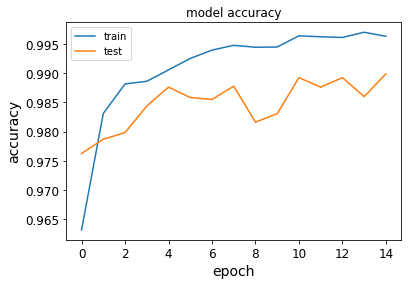

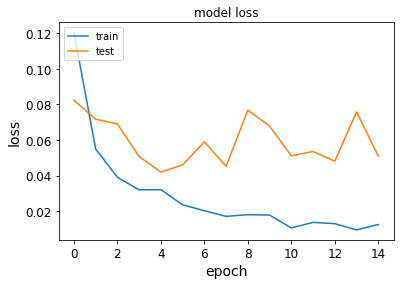

In [29]:
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

Loss curve show the model is little overfit

Evaluate the model

In [30]:
loss,accuracy=model.evaluate(X_test_A,y_test_A)

161/161 [==============================] - 0s 2ms/step - loss: 0.0348 - accuracy: 0.9936


In [31]:
print("Loss: ",loss)
print("Accuracy: ",accuracy)

Loss:  0.034804265946149826
Accuracy:  0.9935784935951233


In [32]:
r = evaluation.shape[0]
evaluation.loc[r] = ['Basic Model',loss,accuracy,len(history.history['loss'])]
evaluation

,Model,Loss,Accuracy,Epochs
0,Basic Model,0.034804,0.993578,15.0


Saving the model

In [33]:
model.save('model0To4')

Test the saved model

In [34]:
saved_model=keras.models.load_model('model0To4')
loss,accuracy=saved_model.evaluate(X_test_A,y_test_A)

161/161 [==============================] - 0s 2ms/step - loss: 0.0348 - accuracy: 0.9936


# Tune the hyperparameters using cross-validation

In [35]:
optimizer=keras.optimizers.Adam(learning_rate=1e-3)
def build_model(n_hidden=1,n_neurons=30,learning_rate=1e-3,input_shape=[28,28]):
    model=keras.models.Sequential()
    model.add(keras.layers.Flatten(input_shape=[28,28])) 
    for layer in range(n_hidden):
        model.add(keras.layers.Dense(n_neurons,activation='elu',kernel_initializer='he_normal'))
    model.add(keras.layers.Dense(5,activation='softmax'))
    optimizer=keras.optimizers.Adam(learning_rate=learning_rate)
    model.compile(loss='sparse_categorical_crossentropy',
              optimizer=optimizer,
              metrics=['accuracy'])
    return model

In [36]:
keras_reg=keras.wrappers.scikit_learn.KerasClassifier(build_model)

In [37]:
tensorboard_cv=keras.callbacks.TensorBoard(get_run_logdir())
checkpoint_cb=keras.callbacks.ModelCheckpoint('rndModel_digit0To4',save_best_only=True)

2023-01-11 12:16:11.993205: I tensorflow/core/profiler/lib/profiler_session.cc:136] Profiler session initializing.
2023-01-11 12:16:11.993248: I tensorflow/core/profiler/lib/profiler_session.cc:155] Profiler session started.
2023-01-11 12:16:12.216287: I tensorflow/core/profiler/lib/profiler_session.cc:172] Profiler session tear down.
2023-01-11 12:16:12.216448: I tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1487] CUPTI activity buffer flushed


In [38]:
from scipy.stats import reciprocal
from sklearn.model_selection import RandomizedSearchCV

param_distribs = {
    "n_hidden": [0, 1, 2, 3,4,5],
    "n_neurons": np.arange(1, 100)               .tolist(),
    "learning_rate": reciprocal(1e-4, 1e-2)      .rvs(1000).tolist(),
}

rnd_search_cv = RandomizedSearchCV(keras_reg, param_distribs, n_iter=10, cv=3, verbose=2)
history=rnd_search_cv.fit(X_train_A, y_train_A, epochs=100,
                  validation_data=(X_valid_A, y_valid_A),
                  callbacks=[checkpoint_cb,early_stopping,tensorboard_cv])

Fitting 3 folds for each of 10 candidates, totalling 30 fits
[CV] n_neurons=4, n_hidden=3, learning_rate=0.0003123893385107206 ....


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Epoch 1/100
  2/510 [..............................] - ETA: 2:23 - loss: 1.6005 - accuracy: 0.1797

2023-01-11 12:16:13.677018: I tensorflow/core/profiler/lib/profiler_session.cc:136] Profiler session initializing.
2023-01-11 12:16:13.677070: I tensorflow/core/profiler/lib/profiler_session.cc:155] Profiler session started.


 79/510 [===>..........................] - ETA: 3s - loss: 1.5713 - accuracy: 0.2708

2023-01-11 12:16:13.989225: I tensorflow/core/profiler/lib/profiler_session.cc:71] Profiler session collecting data.
2023-01-11 12:16:13.989454: I tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1487] CUPTI activity buffer flushed
2023-01-11 12:16:14.132301: I tensorflow/core/profiler/internal/gpu/cupti_collector.cc:228]  GpuTracer has collected 91 callback api events and 79 activity events. 
2023-01-11 12:16:14.136534: I tensorflow/core/profiler/lib/profiler_session.cc:172] Profiler session tear down.
2023-01-11 12:16:14.140304: I tensorflow/core/profiler/rpc/client/save_profile.cc:137] Creating directory: ./my_logs/run_2023_01_11-12_16_11/train/plugins/profile/2023_01_11_12_16_14
2023-01-11 12:16:14.142975: I tensorflow/core/profiler/rpc/client/save_profile.cc:143] Dumped gzipped tool data for trace.json.gz to ./my_logs/run_2023_01_11-12_16_11/train/plugins/profile/2023_01_11_12_16_14/c9ea16180903.trace.json.gz
2023-01-11 12:16:14.147518: I tensorflow/core/profiler/rpc/client/s

510/510 [==============================] - 2s 4ms/step - loss: 1.3194 - accuracy: 0.4846 - val_loss: 0.8586 - val_accuracy: 0.7543
Epoch 2/100
510/510 [==============================] - 2s 3ms/step - loss: 0.7838 - accuracy: 0.7635 - val_loss: 0.6208 - val_accuracy: 0.7878
Epoch 3/100
510/510 [==============================] - 1s 3ms/step - loss: 0.5739 - accuracy: 0.7935 - val_loss: 0.4719 - val_accuracy: 0.8461
Epoch 4/100
510/510 [==============================] - 1s 3ms/step - loss: 0.4293 - accuracy: 0.8640 - val_loss: 0.3485 - val_accuracy: 0.9077
Epoch 5/100
510/510 [==============================] - 1s 3ms/step - loss: 0.3197 - accuracy: 0.9150 - val_loss: 0.2807 - val_accuracy: 0.9240
Epoch 6/100
510/510 [==============================] - 1s 3ms/step - loss: 0.2521 - accuracy: 0.9323 - val_loss: 0.2443 - val_accuracy: 0.9318
Epoch 7/100
510/510 [==============================] - 2s 4ms/step - loss: 0.2193 - accuracy: 0.9411 - val_loss: 0.2235 - val_accuracy: 0.9370
Epoch 8/100

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  1.4min remaining:    0.0s


  2/510 [..............................] - ETA: 2:44 - loss: 1.7107 - accuracy: 0.3516

2023-01-11 12:17:34.811210: I tensorflow/core/profiler/lib/profiler_session.cc:136] Profiler session initializing.
2023-01-11 12:17:34.811265: I tensorflow/core/profiler/lib/profiler_session.cc:155] Profiler session started.


 80/510 [===>..........................] - ETA: 3s - loss: 1.5346 - accuracy: 0.3817

2023-01-11 12:17:35.159209: I tensorflow/core/profiler/lib/profiler_session.cc:71] Profiler session collecting data.
2023-01-11 12:17:35.159490: I tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1487] CUPTI activity buffer flushed
2023-01-11 12:17:35.301268: I tensorflow/core/profiler/internal/gpu/cupti_collector.cc:228]  GpuTracer has collected 91 callback api events and 79 activity events. 
2023-01-11 12:17:35.305284: I tensorflow/core/profiler/lib/profiler_session.cc:172] Profiler session tear down.
2023-01-11 12:17:35.308951: I tensorflow/core/profiler/rpc/client/save_profile.cc:137] Creating directory: ./my_logs/run_2023_01_11-12_16_11/train/plugins/profile/2023_01_11_12_17_35
2023-01-11 12:17:35.311356: I tensorflow/core/profiler/rpc/client/save_profile.cc:143] Dumped gzipped tool data for trace.json.gz to ./my_logs/run_2023_01_11-12_16_11/train/plugins/profile/2023_01_11_12_17_35/c9ea16180903.trace.json.gz
2023-01-11 12:17:35.315649: I tensorflow/core/profiler/rpc/client/s

510/510 [==============================] - 2s 4ms/step - loss: 1.2206 - accuracy: 0.5501 - val_loss: 0.5570 - val_accuracy: 0.8885
Epoch 2/100
510/510 [==============================] - 1s 3ms/step - loss: 0.4854 - accuracy: 0.9002 - val_loss: 0.3373 - val_accuracy: 0.9255
Epoch 3/100
510/510 [==============================] - 1s 3ms/step - loss: 0.3109 - accuracy: 0.9320 - val_loss: 0.2596 - val_accuracy: 0.9344
Epoch 4/100
510/510 [==============================] - 1s 3ms/step - loss: 0.2455 - accuracy: 0.9405 - val_loss: 0.2265 - val_accuracy: 0.9375
Epoch 5/100
510/510 [==============================] - 1s 3ms/step - loss: 0.2113 - accuracy: 0.9435 - val_loss: 0.2051 - val_accuracy: 0.9417
Epoch 6/100
510/510 [==============================] - 1s 3ms/step - loss: 0.1894 - accuracy: 0.9478 - val_loss: 0.1929 - val_accuracy: 0.9453
Epoch 7/100
510/510 [==============================] - 1s 3ms/step - loss: 0.1725 - accuracy: 0.9516 - val_loss: 0.1856 - val_accuracy: 0.9455
Epoch 8/100

2023-01-11 12:18:57.842186: I tensorflow/core/profiler/lib/profiler_session.cc:136] Profiler session initializing.
2023-01-11 12:18:57.842229: I tensorflow/core/profiler/lib/profiler_session.cc:155] Profiler session started.


 80/510 [===>..........................] - ETA: 3s - loss: 1.4290 - accuracy: 0.4132

2023-01-11 12:18:58.088499: I tensorflow/core/profiler/lib/profiler_session.cc:71] Profiler session collecting data.
2023-01-11 12:18:58.088751: I tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1487] CUPTI activity buffer flushed
2023-01-11 12:18:58.231524: I tensorflow/core/profiler/internal/gpu/cupti_collector.cc:228]  GpuTracer has collected 91 callback api events and 79 activity events. 
2023-01-11 12:18:58.235591: I tensorflow/core/profiler/lib/profiler_session.cc:172] Profiler session tear down.
2023-01-11 12:18:58.239208: I tensorflow/core/profiler/rpc/client/save_profile.cc:137] Creating directory: ./my_logs/run_2023_01_11-12_16_11/train/plugins/profile/2023_01_11_12_18_58
2023-01-11 12:18:58.241868: I tensorflow/core/profiler/rpc/client/save_profile.cc:143] Dumped gzipped tool data for trace.json.gz to ./my_logs/run_2023_01_11-12_16_11/train/plugins/profile/2023_01_11_12_18_58/c9ea16180903.trace.json.gz
2023-01-11 12:18:58.246391: I tensorflow/core/profiler/rpc/client/s

510/510 [==============================] - 2s 4ms/step - loss: 1.1071 - accuracy: 0.5967 - val_loss: 0.6519 - val_accuracy: 0.8090
Epoch 2/100
510/510 [==============================] - 1s 3ms/step - loss: 0.5826 - accuracy: 0.8360 - val_loss: 0.4098 - val_accuracy: 0.9116
Epoch 3/100
510/510 [==============================] - 1s 3ms/step - loss: 0.3750 - accuracy: 0.9195 - val_loss: 0.2790 - val_accuracy: 0.9413
Epoch 4/100
510/510 [==============================] - 2s 3ms/step - loss: 0.2617 - accuracy: 0.9406 - val_loss: 0.2225 - val_accuracy: 0.9505
Epoch 5/100
510/510 [==============================] - 2s 4ms/step - loss: 0.2185 - accuracy: 0.9490 - val_loss: 0.1974 - val_accuracy: 0.9554
Epoch 6/100
510/510 [==============================] - 1s 3ms/step - loss: 0.1881 - accuracy: 0.9555 - val_loss: 0.1821 - val_accuracy: 0.9552
Epoch 7/100
510/510 [==============================] - 1s 3ms/step - loss: 0.1699 - accuracy: 0.9582 - val_loss: 0.1698 - val_accuracy: 0.9583
Epoch 8/100

2023-01-11 12:19:50.944939: I tensorflow/core/profiler/lib/profiler_session.cc:136] Profiler session initializing.
2023-01-11 12:19:50.945001: I tensorflow/core/profiler/lib/profiler_session.cc:155] Profiler session started.


 66/510 [==>...........................] - ETA: 3s - loss: 1.0444 - accuracy: 0.6818

2023-01-11 12:19:51.175244: I tensorflow/core/profiler/lib/profiler_session.cc:71] Profiler session collecting data.
2023-01-11 12:19:51.175483: I tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1487] CUPTI activity buffer flushed
2023-01-11 12:19:51.333551: I tensorflow/core/profiler/internal/gpu/cupti_collector.cc:228]  GpuTracer has collected 64 callback api events and 52 activity events. 
2023-01-11 12:19:51.338936: I tensorflow/core/profiler/lib/profiler_session.cc:172] Profiler session tear down.
2023-01-11 12:19:51.342762: I tensorflow/core/profiler/rpc/client/save_profile.cc:137] Creating directory: ./my_logs/run_2023_01_11-12_16_11/train/plugins/profile/2023_01_11_12_19_51
2023-01-11 12:19:51.345383: I tensorflow/core/profiler/rpc/client/save_profile.cc:143] Dumped gzipped tool data for trace.json.gz to ./my_logs/run_2023_01_11-12_16_11/train/plugins/profile/2023_01_11_12_19_51/c9ea16180903.trace.json.gz
2023-01-11 12:19:51.350969: I tensorflow/core/profiler/rpc/client/s

510/510 [==============================] - 3s 5ms/step - loss: 0.4786 - accuracy: 0.8782 - val_loss: 0.1488 - val_accuracy: 0.9580
Epoch 2/100
510/510 [==============================] - 1s 2ms/step - loss: 0.1362 - accuracy: 0.9634 - val_loss: 0.1284 - val_accuracy: 0.9606
Epoch 3/100
510/510 [==============================] - 1s 2ms/step - loss: 0.1073 - accuracy: 0.9674 - val_loss: 0.1156 - val_accuracy: 0.9631
Epoch 4/100
510/510 [==============================] - 1s 3ms/step - loss: 0.1031 - accuracy: 0.9718 - val_loss: 0.1116 - val_accuracy: 0.9663
Epoch 5/100
510/510 [==============================] - 1s 2ms/step - loss: 0.0950 - accuracy: 0.9724 - val_loss: 0.1087 - val_accuracy: 0.9658
Epoch 6/100
510/510 [==============================] - 1s 2ms/step - loss: 0.0911 - accuracy: 0.9745 - val_loss: 0.1046 - val_accuracy: 0.9671
Epoch 7/100
510/510 [==============================] - 1s 2ms/step - loss: 0.0857 - accuracy: 0.9743 - val_loss: 0.1031 - val_accuracy: 0.9679
Epoch 8/100

2023-01-11 12:20:18.127665: I tensorflow/core/profiler/lib/profiler_session.cc:136] Profiler session initializing.
2023-01-11 12:20:18.127707: I tensorflow/core/profiler/lib/profiler_session.cc:155] Profiler session started.
2023-01-11 12:20:18.352371: I tensorflow/core/profiler/lib/profiler_session.cc:71] Profiler session collecting data.
2023-01-11 12:20:18.352578: I tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1487] CUPTI activity buffer flushed
2023-01-11 12:20:18.494896: I tensorflow/core/profiler/internal/gpu/cupti_collector.cc:228]  GpuTracer has collected 64 callback api events and 52 activity events. 
2023-01-11 12:20:18.498293: I tensorflow/core/profiler/lib/profiler_session.cc:172] Profiler session tear down.
2023-01-11 12:20:18.500821: I tensorflow/core/profiler/rpc/client/save_profile.cc:137] Creating directory: ./my_logs/run_2023_01_11-12_16_11/train/plugins/profile/2023_01_11_12_20_18
2023-01-11 12:20:18.502563: I tensorflow/core/profiler/rpc/client/save_profile

510/510 [==============================] - 2s 4ms/step - loss: 0.5000 - accuracy: 0.8658 - val_loss: 0.1484 - val_accuracy: 0.9577
Epoch 2/100
510/510 [==============================] - 1s 2ms/step - loss: 0.1260 - accuracy: 0.9649 - val_loss: 0.1263 - val_accuracy: 0.9601
Epoch 3/100
510/510 [==============================] - 1s 2ms/step - loss: 0.1047 - accuracy: 0.9721 - val_loss: 0.1159 - val_accuracy: 0.9634
Epoch 4/100
510/510 [==============================] - 2s 3ms/step - loss: 0.1019 - accuracy: 0.9694 - val_loss: 0.1140 - val_accuracy: 0.9645
Epoch 5/100
510/510 [==============================] - 2s 3ms/step - loss: 0.0970 - accuracy: 0.9737 - val_loss: 0.1140 - val_accuracy: 0.9637
Epoch 6/100
510/510 [==============================] - 1s 2ms/step - loss: 0.0914 - accuracy: 0.9723 - val_loss: 0.1077 - val_accuracy: 0.9673
Epoch 7/100
510/510 [==============================] - 1s 2ms/step - loss: 0.0832 - accuracy: 0.9757 - val_loss: 0.1060 - val_accuracy: 0.9676
Epoch 8/100

2023-01-11 12:20:48.986999: I tensorflow/core/profiler/lib/profiler_session.cc:136] Profiler session initializing.
2023-01-11 12:20:48.987042: I tensorflow/core/profiler/lib/profiler_session.cc:155] Profiler session started.
2023-01-11 12:20:49.249833: I tensorflow/core/profiler/lib/profiler_session.cc:71] Profiler session collecting data.
2023-01-11 12:20:49.250076: I tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1487] CUPTI activity buffer flushed
2023-01-11 12:20:49.392763: I tensorflow/core/profiler/internal/gpu/cupti_collector.cc:228]  GpuTracer has collected 64 callback api events and 52 activity events. 
2023-01-11 12:20:49.395903: I tensorflow/core/profiler/lib/profiler_session.cc:172] Profiler session tear down.
2023-01-11 12:20:49.398687: I tensorflow/core/profiler/rpc/client/save_profile.cc:137] Creating directory: ./my_logs/run_2023_01_11-12_16_11/train/plugins/profile/2023_01_11_12_20_49
2023-01-11 12:20:49.400527: I tensorflow/core/profiler/rpc/client/save_profile

510/510 [==============================] - 2s 3ms/step - loss: 0.5235 - accuracy: 0.8581 - val_loss: 0.1471 - val_accuracy: 0.9619
Epoch 2/100
510/510 [==============================] - 1s 2ms/step - loss: 0.1386 - accuracy: 0.9609 - val_loss: 0.1243 - val_accuracy: 0.9634
Epoch 3/100
510/510 [==============================] - 1s 3ms/step - loss: 0.1172 - accuracy: 0.9662 - val_loss: 0.1155 - val_accuracy: 0.9647
Epoch 4/100
510/510 [==============================] - 1s 2ms/step - loss: 0.1037 - accuracy: 0.9710 - val_loss: 0.1117 - val_accuracy: 0.9668
Epoch 5/100
510/510 [==============================] - 1s 3ms/step - loss: 0.1028 - accuracy: 0.9702 - val_loss: 0.1100 - val_accuracy: 0.9668
Epoch 6/100
510/510 [==============================] - 2s 4ms/step - loss: 0.0996 - accuracy: 0.9706 - val_loss: 0.1089 - val_accuracy: 0.9675
Epoch 7/100
510/510 [==============================] - 1s 2ms/step - loss: 0.0930 - accuracy: 0.9719 - val_loss: 0.1068 - val_accuracy: 0.9668
Epoch 8/100

2023-01-11 12:21:19.772934: I tensorflow/core/profiler/lib/profiler_session.cc:136] Profiler session initializing.
2023-01-11 12:21:19.772980: I tensorflow/core/profiler/lib/profiler_session.cc:155] Profiler session started.
2023-01-11 12:21:20.035683: I tensorflow/core/profiler/lib/profiler_session.cc:71] Profiler session collecting data.
2023-01-11 12:21:20.035948: I tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1487] CUPTI activity buffer flushed
2023-01-11 12:21:20.177915: I tensorflow/core/profiler/internal/gpu/cupti_collector.cc:228]  GpuTracer has collected 91 callback api events and 79 activity events. 
2023-01-11 12:21:20.181950: I tensorflow/core/profiler/lib/profiler_session.cc:172] Profiler session tear down.
2023-01-11 12:21:20.185431: I tensorflow/core/profiler/rpc/client/save_profile.cc:137] Creating directory: ./my_logs/run_2023_01_11-12_16_11/train/plugins/profile/2023_01_11_12_21_20
2023-01-11 12:21:20.187815: I tensorflow/core/profiler/rpc/client/save_profile

510/510 [==============================] - 2s 4ms/step - loss: 0.2408 - accuracy: 0.9230 - val_loss: 0.0805 - val_accuracy: 0.9758
Epoch 2/100
510/510 [==============================] - 1s 3ms/step - loss: 0.0701 - accuracy: 0.9794 - val_loss: 0.0640 - val_accuracy: 0.9798
Epoch 3/100
510/510 [==============================] - 2s 3ms/step - loss: 0.0388 - accuracy: 0.9882 - val_loss: 0.0673 - val_accuracy: 0.9771
Epoch 4/100
510/510 [==============================] - 1s 3ms/step - loss: 0.0329 - accuracy: 0.9889 - val_loss: 0.0643 - val_accuracy: 0.9801
Epoch 5/100
510/510 [==============================] - 2s 4ms/step - loss: 0.0252 - accuracy: 0.9922 - val_loss: 0.0613 - val_accuracy: 0.9805
Epoch 6/100
510/510 [==============================] - 1s 3ms/step - loss: 0.0195 - accuracy: 0.9937 - val_loss: 0.0720 - val_accuracy: 0.9782
Epoch 7/100
510/510 [==============================] - 1s 3ms/step - loss: 0.0124 - accuracy: 0.9958 - val_loss: 0.0702 - val_accuracy: 0.9816
Epoch 8/100

2023-01-11 12:21:45.634935: I tensorflow/core/profiler/lib/profiler_session.cc:136] Profiler session initializing.
2023-01-11 12:21:45.634981: I tensorflow/core/profiler/lib/profiler_session.cc:155] Profiler session started.
2023-01-11 12:21:45.907288: I tensorflow/core/profiler/lib/profiler_session.cc:71] Profiler session collecting data.


 80/510 [===>..........................] - ETA: 3s - loss: 0.6784 - accuracy: 0.7706

2023-01-11 12:21:45.907527: I tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1487] CUPTI activity buffer flushed
2023-01-11 12:21:46.050295: I tensorflow/core/profiler/internal/gpu/cupti_collector.cc:228]  GpuTracer has collected 91 callback api events and 79 activity events. 
2023-01-11 12:21:46.054641: I tensorflow/core/profiler/lib/profiler_session.cc:172] Profiler session tear down.
2023-01-11 12:21:46.058320: I tensorflow/core/profiler/rpc/client/save_profile.cc:137] Creating directory: ./my_logs/run_2023_01_11-12_16_11/train/plugins/profile/2023_01_11_12_21_46
2023-01-11 12:21:46.060702: I tensorflow/core/profiler/rpc/client/save_profile.cc:143] Dumped gzipped tool data for trace.json.gz to ./my_logs/run_2023_01_11-12_16_11/train/plugins/profile/2023_01_11_12_21_46/c9ea16180903.trace.json.gz
2023-01-11 12:21:46.065330: I tensorflow/core/profiler/rpc/client/save_profile.cc:137] Creating directory: ./my_logs/run_2023_01_11-12_16_11/train/plugins/profile/2023_01_11_12_21_46
2

510/510 [==============================] - 2s 4ms/step - loss: 0.2738 - accuracy: 0.9125 - val_loss: 0.1015 - val_accuracy: 0.9675
Epoch 2/100
510/510 [==============================] - 1s 3ms/step - loss: 0.0655 - accuracy: 0.9796 - val_loss: 0.0785 - val_accuracy: 0.9748
Epoch 3/100
510/510 [==============================] - 1s 3ms/step - loss: 0.0440 - accuracy: 0.9868 - val_loss: 0.0701 - val_accuracy: 0.9767
Epoch 4/100
510/510 [==============================] - 1s 3ms/step - loss: 0.0314 - accuracy: 0.9907 - val_loss: 0.0863 - val_accuracy: 0.9771
Epoch 5/100
510/510 [==============================] - 1s 3ms/step - loss: 0.0282 - accuracy: 0.9895 - val_loss: 0.0821 - val_accuracy: 0.9767
Epoch 6/100
510/510 [==============================] - 1s 3ms/step - loss: 0.0177 - accuracy: 0.9951 - val_loss: 0.0557 - val_accuracy: 0.9850
Epoch 7/100
510/510 [==============================] - 1s 3ms/step - loss: 0.0138 - accuracy: 0.9960 - val_loss: 0.0753 - val_accuracy: 0.9803
Epoch 8/100

2023-01-11 12:22:11.963240: I tensorflow/core/profiler/lib/profiler_session.cc:136] Profiler session initializing.
2023-01-11 12:22:11.963287: I tensorflow/core/profiler/lib/profiler_session.cc:155] Profiler session started.


 53/510 [==>...........................] - ETA: 5s - loss: 0.7992 - accuracy: 0.7160

2023-01-11 12:22:12.281647: I tensorflow/core/profiler/lib/profiler_session.cc:71] Profiler session collecting data.
2023-01-11 12:22:12.281964: I tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1487] CUPTI activity buffer flushed
2023-01-11 12:22:12.440312: I tensorflow/core/profiler/internal/gpu/cupti_collector.cc:228]  GpuTracer has collected 91 callback api events and 79 activity events. 
2023-01-11 12:22:12.446541: I tensorflow/core/profiler/lib/profiler_session.cc:172] Profiler session tear down.
2023-01-11 12:22:12.451744: I tensorflow/core/profiler/rpc/client/save_profile.cc:137] Creating directory: ./my_logs/run_2023_01_11-12_16_11/train/plugins/profile/2023_01_11_12_22_12
2023-01-11 12:22:12.455015: I tensorflow/core/profiler/rpc/client/save_profile.cc:143] Dumped gzipped tool data for trace.json.gz to ./my_logs/run_2023_01_11-12_16_11/train/plugins/profile/2023_01_11_12_22_12/c9ea16180903.trace.json.gz
2023-01-11 12:22:12.462623: I tensorflow/core/profiler/rpc/client/s

510/510 [==============================] - 3s 4ms/step - loss: 0.2753 - accuracy: 0.9119 - val_loss: 0.0873 - val_accuracy: 0.9733
Epoch 2/100
510/510 [==============================] - 1s 3ms/step - loss: 0.0740 - accuracy: 0.9778 - val_loss: 0.0792 - val_accuracy: 0.9774
Epoch 3/100
510/510 [==============================] - 1s 3ms/step - loss: 0.0498 - accuracy: 0.9842 - val_loss: 0.0638 - val_accuracy: 0.9813
Epoch 4/100
510/510 [==============================] - 1s 3ms/step - loss: 0.0326 - accuracy: 0.9900 - val_loss: 0.0821 - val_accuracy: 0.9759
Epoch 5/100
510/510 [==============================] - 1s 3ms/step - loss: 0.0216 - accuracy: 0.9931 - val_loss: 0.0844 - val_accuracy: 0.9782
Epoch 6/100
510/510 [==============================] - 2s 3ms/step - loss: 0.0194 - accuracy: 0.9940 - val_loss: 0.0735 - val_accuracy: 0.9787
Epoch 7/100
510/510 [==============================] - 1s 3ms/step - loss: 0.0153 - accuracy: 0.9949 - val_loss: 0.0644 - val_accuracy: 0.9818
Epoch 8/100

2023-01-11 12:22:32.057646: I tensorflow/core/profiler/lib/profiler_session.cc:136] Profiler session initializing.
2023-01-11 12:22:32.057689: I tensorflow/core/profiler/lib/profiler_session.cc:155] Profiler session started.


 78/510 [===>..........................] - ETA: 3s - loss: 0.6528 - accuracy: 0.7605

2023-01-11 12:22:32.290070: I tensorflow/core/profiler/lib/profiler_session.cc:71] Profiler session collecting data.
2023-01-11 12:22:32.290346: I tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1487] CUPTI activity buffer flushed
2023-01-11 12:22:32.437252: I tensorflow/core/profiler/internal/gpu/cupti_collector.cc:228]  GpuTracer has collected 109 callback api events and 97 activity events. 
2023-01-11 12:22:32.442183: I tensorflow/core/profiler/lib/profiler_session.cc:172] Profiler session tear down.
2023-01-11 12:22:32.447260: I tensorflow/core/profiler/rpc/client/save_profile.cc:137] Creating directory: ./my_logs/run_2023_01_11-12_16_11/train/plugins/profile/2023_01_11_12_22_32
2023-01-11 12:22:32.450545: I tensorflow/core/profiler/rpc/client/save_profile.cc:143] Dumped gzipped tool data for trace.json.gz to ./my_logs/run_2023_01_11-12_16_11/train/plugins/profile/2023_01_11_12_22_32/c9ea16180903.trace.json.gz
2023-01-11 12:22:32.456230: I tensorflow/core/profiler/rpc/client/

510/510 [==============================] - 3s 5ms/step - loss: 0.2658 - accuracy: 0.9093 - val_loss: 0.0937 - val_accuracy: 0.9722
Epoch 2/100
510/510 [==============================] - 2s 4ms/step - loss: 0.0636 - accuracy: 0.9796 - val_loss: 0.0698 - val_accuracy: 0.9766
Epoch 3/100
510/510 [==============================] - 1s 3ms/step - loss: 0.0378 - accuracy: 0.9874 - val_loss: 0.0696 - val_accuracy: 0.9788
Epoch 4/100
510/510 [==============================] - 1s 3ms/step - loss: 0.0295 - accuracy: 0.9910 - val_loss: 0.0690 - val_accuracy: 0.9811
Epoch 5/100
510/510 [==============================] - 1s 3ms/step - loss: 0.0237 - accuracy: 0.9921 - val_loss: 0.0879 - val_accuracy: 0.9746
Epoch 6/100
510/510 [==============================] - 1s 3ms/step - loss: 0.0248 - accuracy: 0.9907 - val_loss: 0.0740 - val_accuracy: 0.9811
Epoch 7/100
510/510 [==============================] - 2s 4ms/step - loss: 0.0113 - accuracy: 0.9963 - val_loss: 0.0767 - val_accuracy: 0.9826
Epoch 8/100

2023-01-11 12:23:01.601863: I tensorflow/core/profiler/lib/profiler_session.cc:136] Profiler session initializing.
2023-01-11 12:23:01.601910: I tensorflow/core/profiler/lib/profiler_session.cc:155] Profiler session started.


 76/510 [===>..........................] - ETA: 3s - loss: 0.5921 - accuracy: 0.7910

2023-01-11 12:23:01.840022: I tensorflow/core/profiler/lib/profiler_session.cc:71] Profiler session collecting data.
2023-01-11 12:23:01.840300: I tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1487] CUPTI activity buffer flushed
2023-01-11 12:23:01.983598: I tensorflow/core/profiler/internal/gpu/cupti_collector.cc:228]  GpuTracer has collected 109 callback api events and 97 activity events. 
2023-01-11 12:23:01.988548: I tensorflow/core/profiler/lib/profiler_session.cc:172] Profiler session tear down.
2023-01-11 12:23:01.993035: I tensorflow/core/profiler/rpc/client/save_profile.cc:137] Creating directory: ./my_logs/run_2023_01_11-12_16_11/train/plugins/profile/2023_01_11_12_23_01
2023-01-11 12:23:01.995952: I tensorflow/core/profiler/rpc/client/save_profile.cc:143] Dumped gzipped tool data for trace.json.gz to ./my_logs/run_2023_01_11-12_16_11/train/plugins/profile/2023_01_11_12_23_01/c9ea16180903.trace.json.gz
2023-01-11 12:23:02.001227: I tensorflow/core/profiler/rpc/client/

510/510 [==============================] - 2s 4ms/step - loss: 0.2408 - accuracy: 0.9193 - val_loss: 0.0977 - val_accuracy: 0.9692
Epoch 2/100
510/510 [==============================] - 2s 3ms/step - loss: 0.0564 - accuracy: 0.9814 - val_loss: 0.0768 - val_accuracy: 0.9777
Epoch 3/100
510/510 [==============================] - 2s 4ms/step - loss: 0.0418 - accuracy: 0.9854 - val_loss: 0.0609 - val_accuracy: 0.9806
Epoch 4/100
510/510 [==============================] - 2s 4ms/step - loss: 0.0337 - accuracy: 0.9872 - val_loss: 0.1169 - val_accuracy: 0.9728
Epoch 5/100
510/510 [==============================] - 1s 3ms/step - loss: 0.0228 - accuracy: 0.9929 - val_loss: 0.0785 - val_accuracy: 0.9777
Epoch 6/100
510/510 [==============================] - 1s 3ms/step - loss: 0.0227 - accuracy: 0.9927 - val_loss: 0.0532 - val_accuracy: 0.9841
Epoch 7/100
510/510 [==============================] - 1s 3ms/step - loss: 0.0170 - accuracy: 0.9952 - val_loss: 0.0889 - val_accuracy: 0.9748
Epoch 8/100

2023-01-11 12:23:29.262023: I tensorflow/core/profiler/lib/profiler_session.cc:136] Profiler session initializing.
2023-01-11 12:23:29.262068: I tensorflow/core/profiler/lib/profiler_session.cc:155] Profiler session started.


 75/510 [===>..........................] - ETA: 3s - loss: 0.7281 - accuracy: 0.7596

2023-01-11 12:23:29.496736: I tensorflow/core/profiler/lib/profiler_session.cc:71] Profiler session collecting data.
2023-01-11 12:23:29.497006: I tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1487] CUPTI activity buffer flushed
2023-01-11 12:23:29.640753: I tensorflow/core/profiler/internal/gpu/cupti_collector.cc:228]  GpuTracer has collected 109 callback api events and 97 activity events. 
2023-01-11 12:23:29.645161: I tensorflow/core/profiler/lib/profiler_session.cc:172] Profiler session tear down.
2023-01-11 12:23:29.649492: I tensorflow/core/profiler/rpc/client/save_profile.cc:137] Creating directory: ./my_logs/run_2023_01_11-12_16_11/train/plugins/profile/2023_01_11_12_23_29
2023-01-11 12:23:29.652307: I tensorflow/core/profiler/rpc/client/save_profile.cc:143] Dumped gzipped tool data for trace.json.gz to ./my_logs/run_2023_01_11-12_16_11/train/plugins/profile/2023_01_11_12_23_29/c9ea16180903.trace.json.gz
2023-01-11 12:23:29.657632: I tensorflow/core/profiler/rpc/client/

510/510 [==============================] - 2s 4ms/step - loss: 0.2836 - accuracy: 0.9101 - val_loss: 0.0920 - val_accuracy: 0.9694
Epoch 2/100
510/510 [==============================] - 1s 3ms/step - loss: 0.0635 - accuracy: 0.9802 - val_loss: 0.0691 - val_accuracy: 0.9790
Epoch 3/100
510/510 [==============================] - 1s 3ms/step - loss: 0.0377 - accuracy: 0.9879 - val_loss: 0.0519 - val_accuracy: 0.9842
Epoch 4/100
510/510 [==============================] - 1s 3ms/step - loss: 0.0278 - accuracy: 0.9906 - val_loss: 0.0666 - val_accuracy: 0.9798
Epoch 5/100
510/510 [==============================] - 2s 3ms/step - loss: 0.0176 - accuracy: 0.9948 - val_loss: 0.0656 - val_accuracy: 0.9821
Epoch 6/100
510/510 [==============================] - 2s 4ms/step - loss: 0.0172 - accuracy: 0.9942 - val_loss: 0.0720 - val_accuracy: 0.9816
Epoch 7/100
510/510 [==============================] - 2s 4ms/step - loss: 0.0158 - accuracy: 0.9947 - val_loss: 0.0596 - val_accuracy: 0.9837
Epoch 8/100

2023-01-11 12:24:04.811349: I tensorflow/core/profiler/lib/profiler_session.cc:136] Profiler session initializing.
2023-01-11 12:24:04.811394: I tensorflow/core/profiler/lib/profiler_session.cc:155] Profiler session started.
2023-01-11 12:24:05.039609: I tensorflow/core/profiler/lib/profiler_session.cc:71] Profiler session collecting data.
2023-01-11 12:24:05.039880: I tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1487] CUPTI activity buffer flushed
2023-01-11 12:24:05.181448: I tensorflow/core/profiler/internal/gpu/cupti_collector.cc:228]  GpuTracer has collected 73 callback api events and 61 activity events. 
2023-01-11 12:24:05.185022: I tensorflow/core/profiler/lib/profiler_session.cc:172] Profiler session tear down.
2023-01-11 12:24:05.187900: I tensorflow/core/profiler/rpc/client/save_profile.cc:137] Creating directory: ./my_logs/run_2023_01_11-12_16_11/train/plugins/profile/2023_01_11_12_24_05
2023-01-11 12:24:05.189949: I tensorflow/core/profiler/rpc/client/save_profile

510/510 [==============================] - 2s 3ms/step - loss: 0.2064 - accuracy: 0.9303 - val_loss: 0.0738 - val_accuracy: 0.9808
Epoch 2/100
510/510 [==============================] - 1s 2ms/step - loss: 0.0588 - accuracy: 0.9820 - val_loss: 0.0649 - val_accuracy: 0.9792
Epoch 3/100
510/510 [==============================] - 1s 2ms/step - loss: 0.0389 - accuracy: 0.9859 - val_loss: 0.1010 - val_accuracy: 0.9746
Epoch 4/100
510/510 [==============================] - 1s 2ms/step - loss: 0.0290 - accuracy: 0.9911 - val_loss: 0.0657 - val_accuracy: 0.9857
Epoch 5/100
510/510 [==============================] - 1s 3ms/step - loss: 0.0200 - accuracy: 0.9939 - val_loss: 0.2238 - val_accuracy: 0.9611
Epoch 6/100
510/510 [==============================] - 2s 3ms/step - loss: 0.0452 - accuracy: 0.9890 - val_loss: 0.1104 - val_accuracy: 0.9816
Epoch 7/100
510/510 [==============================] - 2s 3ms/step - loss: 0.0228 - accuracy: 0.9933 - val_loss: 0.1065 - val_accuracy: 0.9823
Epoch 8/100

2023-01-11 12:24:23.368917: I tensorflow/core/profiler/lib/profiler_session.cc:136] Profiler session initializing.
2023-01-11 12:24:23.368959: I tensorflow/core/profiler/lib/profiler_session.cc:155] Profiler session started.
2023-01-11 12:24:23.590327: I tensorflow/core/profiler/lib/profiler_session.cc:71] Profiler session collecting data.
2023-01-11 12:24:23.590556: I tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1487] CUPTI activity buffer flushed
2023-01-11 12:24:23.733503: I tensorflow/core/profiler/internal/gpu/cupti_collector.cc:228]  GpuTracer has collected 73 callback api events and 61 activity events. 
2023-01-11 12:24:23.736956: I tensorflow/core/profiler/lib/profiler_session.cc:172] Profiler session tear down.
2023-01-11 12:24:23.739991: I tensorflow/core/profiler/rpc/client/save_profile.cc:137] Creating directory: ./my_logs/run_2023_01_11-12_16_11/train/plugins/profile/2023_01_11_12_24_23
2023-01-11 12:24:23.742246: I tensorflow/core/profiler/rpc/client/save_profile

510/510 [==============================] - 2s 3ms/step - loss: 0.2140 - accuracy: 0.9332 - val_loss: 0.0926 - val_accuracy: 0.9720
Epoch 2/100
510/510 [==============================] - 1s 2ms/step - loss: 0.0559 - accuracy: 0.9829 - val_loss: 0.0794 - val_accuracy: 0.9788
Epoch 3/100
510/510 [==============================] - 1s 2ms/step - loss: 0.0409 - accuracy: 0.9872 - val_loss: 0.0782 - val_accuracy: 0.9784
Epoch 4/100
510/510 [==============================] - 1s 2ms/step - loss: 0.0366 - accuracy: 0.9880 - val_loss: 0.0933 - val_accuracy: 0.9780
Epoch 5/100
510/510 [==============================] - 1s 2ms/step - loss: 0.0215 - accuracy: 0.9924 - val_loss: 0.1068 - val_accuracy: 0.9766
Epoch 6/100
510/510 [==============================] - 1s 2ms/step - loss: 0.0231 - accuracy: 0.9924 - val_loss: 0.1050 - val_accuracy: 0.9829
Epoch 7/100
510/510 [==============================] - 1s 2ms/step - loss: 0.0208 - accuracy: 0.9940 - val_loss: 0.0943 - val_accuracy: 0.9813
Epoch 8/100

2023-01-11 12:24:40.999013: I tensorflow/core/profiler/lib/profiler_session.cc:136] Profiler session initializing.
2023-01-11 12:24:40.999066: I tensorflow/core/profiler/lib/profiler_session.cc:155] Profiler session started.
2023-01-11 12:24:41.238383: I tensorflow/core/profiler/lib/profiler_session.cc:71] Profiler session collecting data.
2023-01-11 12:24:41.238650: I tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1487] CUPTI activity buffer flushed
2023-01-11 12:24:41.381156: I tensorflow/core/profiler/internal/gpu/cupti_collector.cc:228]  GpuTracer has collected 73 callback api events and 61 activity events. 
2023-01-11 12:24:41.384746: I tensorflow/core/profiler/lib/profiler_session.cc:172] Profiler session tear down.
2023-01-11 12:24:41.387630: I tensorflow/core/profiler/rpc/client/save_profile.cc:137] Creating directory: ./my_logs/run_2023_01_11-12_16_11/train/plugins/profile/2023_01_11_12_24_41
2023-01-11 12:24:41.389831: I tensorflow/core/profiler/rpc/client/save_profile

510/510 [==============================] - 2s 4ms/step - loss: 0.2055 - accuracy: 0.9278 - val_loss: 0.0916 - val_accuracy: 0.9725
Epoch 2/100
510/510 [==============================] - 1s 3ms/step - loss: 0.0591 - accuracy: 0.9831 - val_loss: 0.0790 - val_accuracy: 0.9792
Epoch 3/100
510/510 [==============================] - 1s 2ms/step - loss: 0.0408 - accuracy: 0.9885 - val_loss: 0.0898 - val_accuracy: 0.9749
Epoch 4/100
510/510 [==============================] - 2s 4ms/step - loss: 0.0343 - accuracy: 0.9894 - val_loss: 0.1189 - val_accuracy: 0.9704
Epoch 5/100
510/510 [==============================] - 2s 5ms/step - loss: 0.0196 - accuracy: 0.9937 - val_loss: 0.1453 - val_accuracy: 0.9701
Epoch 6/100
510/510 [==============================] - 2s 3ms/step - loss: 0.0317 - accuracy: 0.9913 - val_loss: 0.1074 - val_accuracy: 0.9797
Epoch 7/100
510/510 [==============================] - 1s 2ms/step - loss: 0.0200 - accuracy: 0.9949 - val_loss: 0.0841 - val_accuracy: 0.9852
Epoch 8/100

2023-01-11 12:25:00.314641: I tensorflow/core/profiler/lib/profiler_session.cc:136] Profiler session initializing.
2023-01-11 12:25:00.314686: I tensorflow/core/profiler/lib/profiler_session.cc:155] Profiler session started.
2023-01-11 12:25:00.539990: I tensorflow/core/profiler/lib/profiler_session.cc:71] Profiler session collecting data.
2023-01-11 12:25:00.540224: I tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1487] CUPTI activity buffer flushed
2023-01-11 12:25:00.685788: I tensorflow/core/profiler/internal/gpu/cupti_collector.cc:228]  GpuTracer has collected 64 callback api events and 52 activity events. 
2023-01-11 12:25:00.689038: I tensorflow/core/profiler/lib/profiler_session.cc:172] Profiler session tear down.
2023-01-11 12:25:00.691636: I tensorflow/core/profiler/rpc/client/save_profile.cc:137] Creating directory: ./my_logs/run_2023_01_11-12_16_11/train/plugins/profile/2023_01_11_12_25_00
2023-01-11 12:25:00.693452: I tensorflow/core/profiler/rpc/client/save_profile

510/510 [==============================] - 2s 3ms/step - loss: 0.8800 - accuracy: 0.7229 - val_loss: 0.2552 - val_accuracy: 0.9419
Epoch 2/100
510/510 [==============================] - 1s 2ms/step - loss: 0.2302 - accuracy: 0.9461 - val_loss: 0.1811 - val_accuracy: 0.9509
Epoch 3/100
510/510 [==============================] - 1s 2ms/step - loss: 0.1628 - accuracy: 0.9588 - val_loss: 0.1538 - val_accuracy: 0.9570
Epoch 4/100
510/510 [==============================] - 1s 2ms/step - loss: 0.1427 - accuracy: 0.9632 - val_loss: 0.1395 - val_accuracy: 0.9600
Epoch 5/100
510/510 [==============================] - 1s 3ms/step - loss: 0.1286 - accuracy: 0.9657 - val_loss: 0.1325 - val_accuracy: 0.9593
Epoch 6/100
510/510 [==============================] - 1s 2ms/step - loss: 0.1188 - accuracy: 0.9672 - val_loss: 0.1247 - val_accuracy: 0.9619
Epoch 7/100
510/510 [==============================] - 1s 2ms/step - loss: 0.1115 - accuracy: 0.9688 - val_loss: 0.1197 - val_accuracy: 0.9624
Epoch 8/100

2023-01-11 12:26:03.963043: I tensorflow/core/profiler/lib/profiler_session.cc:136] Profiler session initializing.
2023-01-11 12:26:03.963085: I tensorflow/core/profiler/lib/profiler_session.cc:155] Profiler session started.
2023-01-11 12:26:04.191080: I tensorflow/core/profiler/lib/profiler_session.cc:71] Profiler session collecting data.
2023-01-11 12:26:04.191304: I tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1487] CUPTI activity buffer flushed
2023-01-11 12:26:04.334909: I tensorflow/core/profiler/internal/gpu/cupti_collector.cc:228]  GpuTracer has collected 64 callback api events and 52 activity events. 
2023-01-11 12:26:04.338302: I tensorflow/core/profiler/lib/profiler_session.cc:172] Profiler session tear down.
2023-01-11 12:26:04.341016: I tensorflow/core/profiler/rpc/client/save_profile.cc:137] Creating directory: ./my_logs/run_2023_01_11-12_16_11/train/plugins/profile/2023_01_11_12_26_04
2023-01-11 12:26:04.342750: I tensorflow/core/profiler/rpc/client/save_profile

510/510 [==============================] - 2s 3ms/step - loss: 0.8140 - accuracy: 0.7979 - val_loss: 0.2475 - val_accuracy: 0.9434
Epoch 2/100
510/510 [==============================] - 1s 2ms/step - loss: 0.2143 - accuracy: 0.9528 - val_loss: 0.1775 - val_accuracy: 0.9530
Epoch 3/100
510/510 [==============================] - 1s 2ms/step - loss: 0.1547 - accuracy: 0.9617 - val_loss: 0.1521 - val_accuracy: 0.9569
Epoch 4/100
510/510 [==============================] - 1s 2ms/step - loss: 0.1384 - accuracy: 0.9632 - val_loss: 0.1391 - val_accuracy: 0.9605
Epoch 5/100
510/510 [==============================] - 1s 2ms/step - loss: 0.1266 - accuracy: 0.9678 - val_loss: 0.1321 - val_accuracy: 0.9611
Epoch 6/100
510/510 [==============================] - 1s 2ms/step - loss: 0.1171 - accuracy: 0.9665 - val_loss: 0.1258 - val_accuracy: 0.9626
Epoch 7/100
510/510 [==============================] - 1s 3ms/step - loss: 0.1090 - accuracy: 0.9700 - val_loss: 0.1213 - val_accuracy: 0.9637
Epoch 8/100

2023-01-11 12:26:53.144574: I tensorflow/core/profiler/lib/profiler_session.cc:136] Profiler session initializing.
2023-01-11 12:26:53.144618: I tensorflow/core/profiler/lib/profiler_session.cc:155] Profiler session started.
2023-01-11 12:26:53.366044: I tensorflow/core/profiler/lib/profiler_session.cc:71] Profiler session collecting data.
2023-01-11 12:26:53.366271: I tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1487] CUPTI activity buffer flushed
2023-01-11 12:26:53.509575: I tensorflow/core/profiler/internal/gpu/cupti_collector.cc:228]  GpuTracer has collected 64 callback api events and 52 activity events. 
2023-01-11 12:26:53.512922: I tensorflow/core/profiler/lib/profiler_session.cc:172] Profiler session tear down.
2023-01-11 12:26:53.515497: I tensorflow/core/profiler/rpc/client/save_profile.cc:137] Creating directory: ./my_logs/run_2023_01_11-12_16_11/train/plugins/profile/2023_01_11_12_26_53
2023-01-11 12:26:53.517294: I tensorflow/core/profiler/rpc/client/save_profile

510/510 [==============================] - 2s 4ms/step - loss: 0.8781 - accuracy: 0.7608 - val_loss: 0.2521 - val_accuracy: 0.9453
Epoch 2/100
510/510 [==============================] - 2s 3ms/step - loss: 0.2320 - accuracy: 0.9474 - val_loss: 0.1764 - val_accuracy: 0.9551
Epoch 3/100
510/510 [==============================] - 1s 2ms/step - loss: 0.1706 - accuracy: 0.9577 - val_loss: 0.1503 - val_accuracy: 0.9592
Epoch 4/100
510/510 [==============================] - 1s 2ms/step - loss: 0.1440 - accuracy: 0.9617 - val_loss: 0.1372 - val_accuracy: 0.9611
Epoch 5/100
510/510 [==============================] - 1s 2ms/step - loss: 0.1353 - accuracy: 0.9642 - val_loss: 0.1289 - val_accuracy: 0.9624
Epoch 6/100
510/510 [==============================] - 1s 2ms/step - loss: 0.1275 - accuracy: 0.9639 - val_loss: 0.1233 - val_accuracy: 0.9645
Epoch 7/100
510/510 [==============================] - 1s 2ms/step - loss: 0.1175 - accuracy: 0.9690 - val_loss: 0.1194 - val_accuracy: 0.9653
Epoch 8/100

2023-01-11 12:27:49.886620: I tensorflow/core/profiler/lib/profiler_session.cc:136] Profiler session initializing.
2023-01-11 12:27:49.886667: I tensorflow/core/profiler/lib/profiler_session.cc:155] Profiler session started.
2023-01-11 12:27:50.113723: I tensorflow/core/profiler/lib/profiler_session.cc:71] Profiler session collecting data.


 74/510 [===>..........................] - ETA: 3s - loss: 1.1637 - accuracy: 0.5598

2023-01-11 12:27:50.113979: I tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1487] CUPTI activity buffer flushed
2023-01-11 12:27:50.257220: I tensorflow/core/profiler/internal/gpu/cupti_collector.cc:228]  GpuTracer has collected 109 callback api events and 97 activity events. 
2023-01-11 12:27:50.261684: I tensorflow/core/profiler/lib/profiler_session.cc:172] Profiler session tear down.
2023-01-11 12:27:50.266116: I tensorflow/core/profiler/rpc/client/save_profile.cc:137] Creating directory: ./my_logs/run_2023_01_11-12_16_11/train/plugins/profile/2023_01_11_12_27_50
2023-01-11 12:27:50.269113: I tensorflow/core/profiler/rpc/client/save_profile.cc:143] Dumped gzipped tool data for trace.json.gz to ./my_logs/run_2023_01_11-12_16_11/train/plugins/profile/2023_01_11_12_27_50/c9ea16180903.trace.json.gz
2023-01-11 12:27:50.274453: I tensorflow/core/profiler/rpc/client/save_profile.cc:137] Creating directory: ./my_logs/run_2023_01_11-12_16_11/train/plugins/profile/2023_01_11_12_27_50


510/510 [==============================] - 3s 4ms/step - loss: 0.5107 - accuracy: 0.8303 - val_loss: 0.1132 - val_accuracy: 0.9648
Epoch 2/100
510/510 [==============================] - 1s 3ms/step - loss: 0.0963 - accuracy: 0.9713 - val_loss: 0.0899 - val_accuracy: 0.9730
Epoch 3/100
510/510 [==============================] - 1s 3ms/step - loss: 0.0654 - accuracy: 0.9802 - val_loss: 0.0863 - val_accuracy: 0.9722
Epoch 4/100
510/510 [==============================] - 1s 3ms/step - loss: 0.0550 - accuracy: 0.9827 - val_loss: 0.0689 - val_accuracy: 0.9787
Epoch 5/100
510/510 [==============================] - 2s 4ms/step - loss: 0.0422 - accuracy: 0.9873 - val_loss: 0.0679 - val_accuracy: 0.9787
Epoch 6/100
510/510 [==============================] - 1s 3ms/step - loss: 0.0349 - accuracy: 0.9902 - val_loss: 0.0595 - val_accuracy: 0.9811
Epoch 7/100
510/510 [==============================] - 1s 3ms/step - loss: 0.0262 - accuracy: 0.9924 - val_loss: 0.0576 - val_accuracy: 0.9816
Epoch 8/100

2023-01-11 12:28:22.125531: I tensorflow/core/profiler/lib/profiler_session.cc:136] Profiler session initializing.
2023-01-11 12:28:22.125613: I tensorflow/core/profiler/lib/profiler_session.cc:155] Profiler session started.


510/510 [==============================] - 3s 5ms/step - loss: 0.5142 - accuracy: 0.8298 - val_loss: 0.1219 - val_accuracy: 0.9618
Epoch 2/100
510/510 [==============================] - 1s 3ms/step - loss: 0.0911 - accuracy: 0.9731 - val_loss: 0.0965 - val_accuracy: 0.9709
Epoch 3/100
510/510 [==============================] - 1s 3ms/step - loss: 0.0668 - accuracy: 0.9800 - val_loss: 0.0835 - val_accuracy: 0.9733
Epoch 4/100
510/510 [==============================] - 2s 4ms/step - loss: 0.0565 - accuracy: 0.9822 - val_loss: 0.0783 - val_accuracy: 0.9751
Epoch 5/100
510/510 [==============================] - 1s 3ms/step - loss: 0.0453 - accuracy: 0.9865 - val_loss: 0.0788 - val_accuracy: 0.9756
Epoch 6/100
510/510 [==============================] - 1s 3ms/step - loss: 0.0349 - accuracy: 0.9890 - val_loss: 0.0658 - val_accuracy: 0.9782
Epoch 7/100
510/510 [==============================] - 1s 3ms/step - loss: 0.0263 - accuracy: 0.9933 - val_loss: 0.0639 - val_accuracy: 0.9813
Epoch 8/100

2023-01-11 12:28:22.464216: I tensorflow/core/profiler/lib/profiler_session.cc:71] Profiler session collecting data.
2023-01-11 12:28:22.464454: I tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1487] CUPTI activity buffer flushed
2023-01-11 12:28:22.618769: I tensorflow/core/profiler/internal/gpu/cupti_collector.cc:228]  GpuTracer has collected 109 callback api events and 97 activity events. 
2023-01-11 12:28:22.625734: I tensorflow/core/profiler/lib/profiler_session.cc:172] Profiler session tear down.
2023-01-11 12:28:22.631819: I tensorflow/core/profiler/rpc/client/save_profile.cc:137] Creating directory: ./my_logs/run_2023_01_11-12_16_11/train/plugins/profile/2023_01_11_12_28_22
2023-01-11 12:28:22.635760: I tensorflow/core/profiler/rpc/client/save_profile.cc:143] Dumped gzipped tool data for trace.json.gz to ./my_logs/run_2023_01_11-12_16_11/train/plugins/profile/2023_01_11_12_28_22/c9ea16180903.trace.json.gz
2023-01-11 12:28:22.644045: I tensorflow/core/profiler/rpc/client/

 76/510 [===>..........................] - ETA: 3s - loss: 1.1597 - accuracy: 0.5421

2023-01-11 12:29:01.268317: I tensorflow/core/profiler/lib/profiler_session.cc:71] Profiler session collecting data.
2023-01-11 12:29:01.268578: I tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1487] CUPTI activity buffer flushed
2023-01-11 12:29:01.411330: I tensorflow/core/profiler/internal/gpu/cupti_collector.cc:228]  GpuTracer has collected 109 callback api events and 97 activity events. 
2023-01-11 12:29:01.415759: I tensorflow/core/profiler/lib/profiler_session.cc:172] Profiler session tear down.
2023-01-11 12:29:01.420244: I tensorflow/core/profiler/rpc/client/save_profile.cc:137] Creating directory: ./my_logs/run_2023_01_11-12_16_11/train/plugins/profile/2023_01_11_12_29_01
2023-01-11 12:29:01.423163: I tensorflow/core/profiler/rpc/client/save_profile.cc:143] Dumped gzipped tool data for trace.json.gz to ./my_logs/run_2023_01_11-12_16_11/train/plugins/profile/2023_01_11_12_29_01/c9ea16180903.trace.json.gz
2023-01-11 12:29:01.428601: I tensorflow/core/profiler/rpc/client/

510/510 [==============================] - 2s 4ms/step - loss: 0.5125 - accuracy: 0.8197 - val_loss: 0.1185 - val_accuracy: 0.9640
Epoch 2/100
510/510 [==============================] - 1s 3ms/step - loss: 0.1012 - accuracy: 0.9663 - val_loss: 0.0942 - val_accuracy: 0.9714
Epoch 3/100
510/510 [==============================] - 1s 3ms/step - loss: 0.0739 - accuracy: 0.9757 - val_loss: 0.0828 - val_accuracy: 0.9743
Epoch 4/100
510/510 [==============================] - 1s 3ms/step - loss: 0.0544 - accuracy: 0.9830 - val_loss: 0.0757 - val_accuracy: 0.9772
Epoch 5/100
510/510 [==============================] - 2s 3ms/step - loss: 0.0443 - accuracy: 0.9868 - val_loss: 0.0707 - val_accuracy: 0.9766
Epoch 6/100
510/510 [==============================] - 1s 3ms/step - loss: 0.0360 - accuracy: 0.9902 - val_loss: 0.0728 - val_accuracy: 0.9779
Epoch 7/100
510/510 [==============================] - 1s 3ms/step - loss: 0.0298 - accuracy: 0.9906 - val_loss: 0.0597 - val_accuracy: 0.9805
Epoch 8/100

2023-01-11 12:29:28.572569: I tensorflow/core/profiler/lib/profiler_session.cc:136] Profiler session initializing.
2023-01-11 12:29:28.572610: I tensorflow/core/profiler/lib/profiler_session.cc:155] Profiler session started.
2023-01-11 12:29:28.799752: I tensorflow/core/profiler/lib/profiler_session.cc:71] Profiler session collecting data.
2023-01-11 12:29:28.799988: I tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1487] CUPTI activity buffer flushed
2023-01-11 12:29:28.943661: I tensorflow/core/profiler/internal/gpu/cupti_collector.cc:228]  GpuTracer has collected 64 callback api events and 52 activity events. 
2023-01-11 12:29:28.946877: I tensorflow/core/profiler/lib/profiler_session.cc:172] Profiler session tear down.
2023-01-11 12:29:28.949553: I tensorflow/core/profiler/rpc/client/save_profile.cc:137] Creating directory: ./my_logs/run_2023_01_11-12_16_11/train/plugins/profile/2023_01_11_12_29_28
2023-01-11 12:29:28.951421: I tensorflow/core/profiler/rpc/client/save_profile

510/510 [==============================] - 3s 5ms/step - loss: 1.0500 - accuracy: 0.7031 - val_loss: 0.3895 - val_accuracy: 0.9284
Epoch 2/100
510/510 [==============================] - 2s 4ms/step - loss: 0.3447 - accuracy: 0.9343 - val_loss: 0.2504 - val_accuracy: 0.9437
Epoch 3/100
510/510 [==============================] - 2s 3ms/step - loss: 0.2310 - accuracy: 0.9482 - val_loss: 0.2006 - val_accuracy: 0.9496
Epoch 4/100
510/510 [==============================] - 2s 3ms/step - loss: 0.1883 - accuracy: 0.9555 - val_loss: 0.1746 - val_accuracy: 0.9544
Epoch 5/100
510/510 [==============================] - 1s 3ms/step - loss: 0.1654 - accuracy: 0.9574 - val_loss: 0.1591 - val_accuracy: 0.9556
Epoch 6/100
510/510 [==============================] - 1s 2ms/step - loss: 0.1477 - accuracy: 0.9617 - val_loss: 0.1481 - val_accuracy: 0.9587
Epoch 7/100
510/510 [==============================] - 1s 2ms/step - loss: 0.1373 - accuracy: 0.9627 - val_loss: 0.1398 - val_accuracy: 0.9601
Epoch 8/100

2023-01-11 12:31:07.596516: I tensorflow/core/profiler/lib/profiler_session.cc:136] Profiler session initializing.
2023-01-11 12:31:07.596561: I tensorflow/core/profiler/lib/profiler_session.cc:155] Profiler session started.
2023-01-11 12:31:07.814535: I tensorflow/core/profiler/lib/profiler_session.cc:71] Profiler session collecting data.
2023-01-11 12:31:07.814775: I tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1487] CUPTI activity buffer flushed
2023-01-11 12:31:07.957724: I tensorflow/core/profiler/internal/gpu/cupti_collector.cc:228]  GpuTracer has collected 64 callback api events and 52 activity events. 
2023-01-11 12:31:07.960854: I tensorflow/core/profiler/lib/profiler_session.cc:172] Profiler session tear down.
2023-01-11 12:31:07.963464: I tensorflow/core/profiler/rpc/client/save_profile.cc:137] Creating directory: ./my_logs/run_2023_01_11-12_16_11/train/plugins/profile/2023_01_11_12_31_07
2023-01-11 12:31:07.965200: I tensorflow/core/profiler/rpc/client/save_profile

510/510 [==============================] - 2s 4ms/step - loss: 1.0724 - accuracy: 0.6655 - val_loss: 0.3958 - val_accuracy: 0.9260
Epoch 2/100
510/510 [==============================] - 1s 2ms/step - loss: 0.3422 - accuracy: 0.9335 - val_loss: 0.2546 - val_accuracy: 0.9411
Epoch 3/100
510/510 [==============================] - 1s 2ms/step - loss: 0.2275 - accuracy: 0.9490 - val_loss: 0.2041 - val_accuracy: 0.9486
Epoch 4/100
510/510 [==============================] - 1s 2ms/step - loss: 0.1895 - accuracy: 0.9548 - val_loss: 0.1778 - val_accuracy: 0.9526
Epoch 5/100
510/510 [==============================] - 1s 2ms/step - loss: 0.1657 - accuracy: 0.9585 - val_loss: 0.1624 - val_accuracy: 0.9548
Epoch 6/100
510/510 [==============================] - 1s 2ms/step - loss: 0.1490 - accuracy: 0.9602 - val_loss: 0.1515 - val_accuracy: 0.9564
Epoch 7/100
510/510 [==============================] - 1s 2ms/step - loss: 0.1366 - accuracy: 0.9649 - val_loss: 0.1432 - val_accuracy: 0.9587
Epoch 8/100

2023-01-11 12:32:42.898625: I tensorflow/core/profiler/lib/profiler_session.cc:136] Profiler session initializing.
2023-01-11 12:32:42.898670: I tensorflow/core/profiler/lib/profiler_session.cc:155] Profiler session started.
2023-01-11 12:32:43.129625: I tensorflow/core/profiler/lib/profiler_session.cc:71] Profiler session collecting data.
2023-01-11 12:32:43.129835: I tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1487] CUPTI activity buffer flushed
2023-01-11 12:32:43.272087: I tensorflow/core/profiler/internal/gpu/cupti_collector.cc:228]  GpuTracer has collected 64 callback api events and 52 activity events. 
2023-01-11 12:32:43.275294: I tensorflow/core/profiler/lib/profiler_session.cc:172] Profiler session tear down.
2023-01-11 12:32:43.277804: I tensorflow/core/profiler/rpc/client/save_profile.cc:137] Creating directory: ./my_logs/run_2023_01_11-12_16_11/train/plugins/profile/2023_01_11_12_32_43
2023-01-11 12:32:43.279575: I tensorflow/core/profiler/rpc/client/save_profile

510/510 [==============================] - 2s 3ms/step - loss: 1.1112 - accuracy: 0.6415 - val_loss: 0.4042 - val_accuracy: 0.9260
Epoch 2/100
510/510 [==============================] - 1s 2ms/step - loss: 0.3643 - accuracy: 0.9330 - val_loss: 0.2567 - val_accuracy: 0.9417
Epoch 3/100
510/510 [==============================] - 1s 2ms/step - loss: 0.2477 - accuracy: 0.9447 - val_loss: 0.2046 - val_accuracy: 0.9497
Epoch 4/100
510/510 [==============================] - 1s 3ms/step - loss: 0.2011 - accuracy: 0.9524 - val_loss: 0.1778 - val_accuracy: 0.9528
Epoch 5/100
510/510 [==============================] - 1s 2ms/step - loss: 0.1775 - accuracy: 0.9568 - val_loss: 0.1607 - val_accuracy: 0.9575
Epoch 6/100
510/510 [==============================] - 1s 2ms/step - loss: 0.1607 - accuracy: 0.9568 - val_loss: 0.1494 - val_accuracy: 0.9598
Epoch 7/100
510/510 [==============================] - 1s 2ms/step - loss: 0.1478 - accuracy: 0.9599 - val_loss: 0.1411 - val_accuracy: 0.9619
Epoch 8/100

2023-01-11 12:33:54.594602: I tensorflow/core/profiler/lib/profiler_session.cc:136] Profiler session initializing.
2023-01-11 12:33:54.594647: I tensorflow/core/profiler/lib/profiler_session.cc:155] Profiler session started.
2023-01-11 12:33:54.829909: I tensorflow/core/profiler/lib/profiler_session.cc:71] Profiler session collecting data.
2023-01-11 12:33:54.830164: I tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1487] CUPTI activity buffer flushed
2023-01-11 12:33:54.972249: I tensorflow/core/profiler/internal/gpu/cupti_collector.cc:228]  GpuTracer has collected 83 callback api events and 71 activity events. 
2023-01-11 12:33:54.976056: I tensorflow/core/profiler/lib/profiler_session.cc:172] Profiler session tear down.
2023-01-11 12:33:54.979481: I tensorflow/core/profiler/rpc/client/save_profile.cc:137] Creating directory: ./my_logs/run_2023_01_11-12_16_11/train/plugins/profile/2023_01_11_12_33_54
2023-01-11 12:33:54.981835: I tensorflow/core/profiler/rpc/client/save_profile

510/510 [==============================] - 2s 4ms/step - loss: 0.2695 - accuracy: 0.9203 - val_loss: 0.0986 - val_accuracy: 0.9699
Epoch 2/100
510/510 [==============================] - 1s 3ms/step - loss: 0.0855 - accuracy: 0.9748 - val_loss: 0.0787 - val_accuracy: 0.9758
Epoch 3/100
510/510 [==============================] - 1s 3ms/step - loss: 0.0539 - accuracy: 0.9836 - val_loss: 0.0761 - val_accuracy: 0.9753
Epoch 4/100
510/510 [==============================] - 1s 3ms/step - loss: 0.0451 - accuracy: 0.9868 - val_loss: 0.0585 - val_accuracy: 0.9813
Epoch 5/100
510/510 [==============================] - 1s 3ms/step - loss: 0.0299 - accuracy: 0.9905 - val_loss: 0.0682 - val_accuracy: 0.9779
Epoch 6/100
510/510 [==============================] - 1s 3ms/step - loss: 0.0236 - accuracy: 0.9934 - val_loss: 0.0619 - val_accuracy: 0.9811
Epoch 7/100
510/510 [==============================] - 1s 3ms/step - loss: 0.0168 - accuracy: 0.9940 - val_loss: 0.0534 - val_accuracy: 0.9831
Epoch 8/100

2023-01-11 12:34:27.978715: I tensorflow/core/profiler/lib/profiler_session.cc:136] Profiler session initializing.
2023-01-11 12:34:27.978764: I tensorflow/core/profiler/lib/profiler_session.cc:155] Profiler session started.
2023-01-11 12:34:28.224569: I tensorflow/core/profiler/lib/profiler_session.cc:71] Profiler session collecting data.
2023-01-11 12:34:28.224808: I tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1487] CUPTI activity buffer flushed
2023-01-11 12:34:28.366344: I tensorflow/core/profiler/internal/gpu/cupti_collector.cc:228]  GpuTracer has collected 83 callback api events and 71 activity events. 
2023-01-11 12:34:28.370305: I tensorflow/core/profiler/lib/profiler_session.cc:172] Profiler session tear down.
2023-01-11 12:34:28.373610: I tensorflow/core/profiler/rpc/client/save_profile.cc:137] Creating directory: ./my_logs/run_2023_01_11-12_16_11/train/plugins/profile/2023_01_11_12_34_28
2023-01-11 12:34:28.375813: I tensorflow/core/profiler/rpc/client/save_profile

510/510 [==============================] - 2s 4ms/step - loss: 0.2928 - accuracy: 0.9070 - val_loss: 0.1036 - val_accuracy: 0.9660
Epoch 2/100
510/510 [==============================] - 1s 3ms/step - loss: 0.0805 - accuracy: 0.9753 - val_loss: 0.0787 - val_accuracy: 0.9754
Epoch 3/100
510/510 [==============================] - 1s 3ms/step - loss: 0.0529 - accuracy: 0.9838 - val_loss: 0.0745 - val_accuracy: 0.9762
Epoch 4/100
510/510 [==============================] - 1s 3ms/step - loss: 0.0424 - accuracy: 0.9865 - val_loss: 0.0771 - val_accuracy: 0.9762
Epoch 5/100
510/510 [==============================] - 1s 3ms/step - loss: 0.0326 - accuracy: 0.9901 - val_loss: 0.0687 - val_accuracy: 0.9774
Epoch 6/100
510/510 [==============================] - 1s 3ms/step - loss: 0.0217 - accuracy: 0.9948 - val_loss: 0.0506 - val_accuracy: 0.9834
Epoch 7/100
510/510 [==============================] - 2s 3ms/step - loss: 0.0155 - accuracy: 0.9955 - val_loss: 0.0613 - val_accuracy: 0.9808
Epoch 8/100

2023-01-11 12:34:52.383478: I tensorflow/core/profiler/lib/profiler_session.cc:136] Profiler session initializing.
2023-01-11 12:34:52.383526: I tensorflow/core/profiler/lib/profiler_session.cc:155] Profiler session started.
2023-01-11 12:34:52.618801: I tensorflow/core/profiler/lib/profiler_session.cc:71] Profiler session collecting data.
2023-01-11 12:34:52.619063: I tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1487] CUPTI activity buffer flushed
2023-01-11 12:34:52.761631: I tensorflow/core/profiler/internal/gpu/cupti_collector.cc:228]  GpuTracer has collected 83 callback api events and 71 activity events. 
2023-01-11 12:34:52.765306: I tensorflow/core/profiler/lib/profiler_session.cc:172] Profiler session tear down.
2023-01-11 12:34:52.768497: I tensorflow/core/profiler/rpc/client/save_profile.cc:137] Creating directory: ./my_logs/run_2023_01_11-12_16_11/train/plugins/profile/2023_01_11_12_34_52
2023-01-11 12:34:52.770924: I tensorflow/core/profiler/rpc/client/save_profile

510/510 [==============================] - 2s 4ms/step - loss: 0.3312 - accuracy: 0.8922 - val_loss: 0.0958 - val_accuracy: 0.9715
Epoch 2/100
510/510 [==============================] - 1s 3ms/step - loss: 0.0800 - accuracy: 0.9772 - val_loss: 0.0770 - val_accuracy: 0.9756
Epoch 3/100
510/510 [==============================] - 1s 3ms/step - loss: 0.0563 - accuracy: 0.9822 - val_loss: 0.0747 - val_accuracy: 0.9762
Epoch 4/100
510/510 [==============================] - 1s 3ms/step - loss: 0.0372 - accuracy: 0.9904 - val_loss: 0.0807 - val_accuracy: 0.9741
Epoch 5/100
510/510 [==============================] - 2s 3ms/step - loss: 0.0261 - accuracy: 0.9933 - val_loss: 0.0600 - val_accuracy: 0.9808
Epoch 6/100
510/510 [==============================] - 1s 3ms/step - loss: 0.0228 - accuracy: 0.9946 - val_loss: 0.0564 - val_accuracy: 0.9816
Epoch 7/100
510/510 [==============================] - 1s 3ms/step - loss: 0.0137 - accuracy: 0.9967 - val_loss: 0.0582 - val_accuracy: 0.9831
Epoch 8/100

2023-01-11 12:35:20.293369: I tensorflow/core/profiler/lib/profiler_session.cc:136] Profiler session initializing.
2023-01-11 12:35:20.293431: I tensorflow/core/profiler/lib/profiler_session.cc:155] Profiler session started.


 57/510 [==>...........................] - ETA: 5s - loss: 1.6346 - accuracy: 0.2299

2023-01-11 12:35:20.616256: I tensorflow/core/profiler/lib/profiler_session.cc:71] Profiler session collecting data.
2023-01-11 12:35:20.616473: I tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1487] CUPTI activity buffer flushed
2023-01-11 12:35:20.778676: I tensorflow/core/profiler/internal/gpu/cupti_collector.cc:228]  GpuTracer has collected 64 callback api events and 52 activity events. 
2023-01-11 12:35:20.783838: I tensorflow/core/profiler/lib/profiler_session.cc:172] Profiler session tear down.
2023-01-11 12:35:20.788086: I tensorflow/core/profiler/rpc/client/save_profile.cc:137] Creating directory: ./my_logs/run_2023_01_11-12_16_11/train/plugins/profile/2023_01_11_12_35_20
2023-01-11 12:35:20.790923: I tensorflow/core/profiler/rpc/client/save_profile.cc:143] Dumped gzipped tool data for trace.json.gz to ./my_logs/run_2023_01_11-12_16_11/train/plugins/profile/2023_01_11_12_35_20/c9ea16180903.trace.json.gz
2023-01-11 12:35:20.797359: I tensorflow/core/profiler/rpc/client/s

510/510 [==============================] - 3s 5ms/step - loss: 1.1667 - accuracy: 0.5884 - val_loss: 0.4319 - val_accuracy: 0.9255
Epoch 2/100
510/510 [==============================] - 2s 4ms/step - loss: 0.3799 - accuracy: 0.9315 - val_loss: 0.2667 - val_accuracy: 0.9429
Epoch 3/100
510/510 [==============================] - 2s 4ms/step - loss: 0.2479 - accuracy: 0.9458 - val_loss: 0.2095 - val_accuracy: 0.9505
Epoch 4/100
510/510 [==============================] - 2s 3ms/step - loss: 0.1995 - accuracy: 0.9531 - val_loss: 0.1804 - val_accuracy: 0.9533
Epoch 5/100
510/510 [==============================] - 1s 2ms/step - loss: 0.1731 - accuracy: 0.9568 - val_loss: 0.1630 - val_accuracy: 0.9552
Epoch 6/100
510/510 [==============================] - 1s 2ms/step - loss: 0.1536 - accuracy: 0.9596 - val_loss: 0.1511 - val_accuracy: 0.9572
Epoch 7/100
510/510 [==============================] - 1s 2ms/step - loss: 0.1417 - accuracy: 0.9623 - val_loss: 0.1422 - val_accuracy: 0.9595
Epoch 8/100

2023-01-11 12:36:57.322024: I tensorflow/core/profiler/lib/profiler_session.cc:136] Profiler session initializing.
2023-01-11 12:36:57.322159: I tensorflow/core/profiler/lib/profiler_session.cc:155] Profiler session started.
2023-01-11 12:36:57.550500: I tensorflow/core/profiler/lib/profiler_session.cc:71] Profiler session collecting data.
2023-01-11 12:36:57.550718: I tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1487] CUPTI activity buffer flushed
2023-01-11 12:36:57.695461: I tensorflow/core/profiler/internal/gpu/cupti_collector.cc:228]  GpuTracer has collected 64 callback api events and 52 activity events. 
2023-01-11 12:36:57.698861: I tensorflow/core/profiler/lib/profiler_session.cc:172] Profiler session tear down.
2023-01-11 12:36:57.701422: I tensorflow/core/profiler/rpc/client/save_profile.cc:137] Creating directory: ./my_logs/run_2023_01_11-12_16_11/train/plugins/profile/2023_01_11_12_36_57
2023-01-11 12:36:57.703211: I tensorflow/core/profiler/rpc/client/save_profile

510/510 [==============================] - 2s 3ms/step - loss: 1.1409 - accuracy: 0.6242 - val_loss: 0.4233 - val_accuracy: 0.9276
Epoch 2/100
510/510 [==============================] - 1s 2ms/step - loss: 0.3619 - accuracy: 0.9360 - val_loss: 0.2640 - val_accuracy: 0.9406
Epoch 3/100
510/510 [==============================] - 1s 3ms/step - loss: 0.2363 - accuracy: 0.9495 - val_loss: 0.2089 - val_accuracy: 0.9484
Epoch 4/100
510/510 [==============================] - 1s 2ms/step - loss: 0.1922 - accuracy: 0.9543 - val_loss: 0.1809 - val_accuracy: 0.9525
Epoch 5/100
510/510 [==============================] - 1s 2ms/step - loss: 0.1697 - accuracy: 0.9581 - val_loss: 0.1647 - val_accuracy: 0.9554
Epoch 6/100
510/510 [==============================] - 1s 2ms/step - loss: 0.1517 - accuracy: 0.9594 - val_loss: 0.1533 - val_accuracy: 0.9579
Epoch 7/100
510/510 [==============================] - 1s 2ms/step - loss: 0.1387 - accuracy: 0.9641 - val_loss: 0.1447 - val_accuracy: 0.9590
Epoch 8/100

2023-01-11 12:38:33.612493: I tensorflow/core/profiler/lib/profiler_session.cc:136] Profiler session initializing.
2023-01-11 12:38:33.612537: I tensorflow/core/profiler/lib/profiler_session.cc:155] Profiler session started.
2023-01-11 12:38:33.829635: I tensorflow/core/profiler/lib/profiler_session.cc:71] Profiler session collecting data.
2023-01-11 12:38:33.829860: I tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1487] CUPTI activity buffer flushed
2023-01-11 12:38:33.972967: I tensorflow/core/profiler/internal/gpu/cupti_collector.cc:228]  GpuTracer has collected 64 callback api events and 52 activity events. 
2023-01-11 12:38:33.976383: I tensorflow/core/profiler/lib/profiler_session.cc:172] Profiler session tear down.
2023-01-11 12:38:33.978948: I tensorflow/core/profiler/rpc/client/save_profile.cc:137] Creating directory: ./my_logs/run_2023_01_11-12_16_11/train/plugins/profile/2023_01_11_12_38_33
2023-01-11 12:38:33.980654: I tensorflow/core/profiler/rpc/client/save_profile

510/510 [==============================] - 2s 3ms/step - loss: 1.1511 - accuracy: 0.6198 - val_loss: 0.4116 - val_accuracy: 0.9315
Epoch 2/100
510/510 [==============================] - 1s 2ms/step - loss: 0.3699 - accuracy: 0.9329 - val_loss: 0.2608 - val_accuracy: 0.9429
Epoch 3/100
510/510 [==============================] - 1s 2ms/step - loss: 0.2517 - accuracy: 0.9434 - val_loss: 0.2081 - val_accuracy: 0.9497
Epoch 4/100
510/510 [==============================] - 1s 2ms/step - loss: 0.2037 - accuracy: 0.9523 - val_loss: 0.1809 - val_accuracy: 0.9530
Epoch 5/100
510/510 [==============================] - 1s 3ms/step - loss: 0.1812 - accuracy: 0.9548 - val_loss: 0.1637 - val_accuracy: 0.9567
Epoch 6/100
510/510 [==============================] - 1s 2ms/step - loss: 0.1644 - accuracy: 0.9564 - val_loss: 0.1522 - val_accuracy: 0.9583
Epoch 7/100
510/510 [==============================] - 1s 2ms/step - loss: 0.1501 - accuracy: 0.9593 - val_loss: 0.1436 - val_accuracy: 0.9611
Epoch 8/100

[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed: 23.8min finished


  2/765 [..............................] - ETA: 3:33 - loss: 1.9312 - accuracy: 0.1797

2023-01-11 12:40:04.384337: I tensorflow/core/profiler/lib/profiler_session.cc:136] Profiler session initializing.
2023-01-11 12:40:04.384402: I tensorflow/core/profiler/lib/profiler_session.cc:155] Profiler session started.


 46/765 [>.............................] - ETA: 10s - loss: 0.9146 - accuracy: 0.6542

2023-01-11 12:40:04.706073: I tensorflow/core/profiler/lib/profiler_session.cc:71] Profiler session collecting data.
2023-01-11 12:40:04.706376: I tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1487] CUPTI activity buffer flushed
2023-01-11 12:40:04.863470: I tensorflow/core/profiler/internal/gpu/cupti_collector.cc:228]  GpuTracer has collected 109 callback api events and 97 activity events. 
2023-01-11 12:40:04.870449: I tensorflow/core/profiler/lib/profiler_session.cc:172] Profiler session tear down.
2023-01-11 12:40:04.876416: I tensorflow/core/profiler/rpc/client/save_profile.cc:137] Creating directory: ./my_logs/run_2023_01_11-12_16_11/train/plugins/profile/2023_01_11_12_40_04
2023-01-11 12:40:04.880503: I tensorflow/core/profiler/rpc/client/save_profile.cc:143] Dumped gzipped tool data for trace.json.gz to ./my_logs/run_2023_01_11-12_16_11/train/plugins/profile/2023_01_11_12_40_04/c9ea16180903.trace.json.gz
2023-01-11 12:40:04.888411: I tensorflow/core/profiler/rpc/client/

765/765 [==============================] - 5s 5ms/step - loss: 0.2314 - accuracy: 0.9225 - val_loss: 0.0699 - val_accuracy: 0.9787
Epoch 2/100
765/765 [==============================] - 3s 4ms/step - loss: 0.0539 - accuracy: 0.9828 - val_loss: 0.0591 - val_accuracy: 0.9834
Epoch 3/100
765/765 [==============================] - 2s 3ms/step - loss: 0.0395 - accuracy: 0.9871 - val_loss: 0.0571 - val_accuracy: 0.9836
Epoch 4/100
765/765 [==============================] - 2s 3ms/step - loss: 0.0292 - accuracy: 0.9907 - val_loss: 0.0696 - val_accuracy: 0.9805
Epoch 5/100
765/765 [==============================] - 2s 2ms/step - loss: 0.0196 - accuracy: 0.9942 - val_loss: 0.0488 - val_accuracy: 0.9867
Epoch 6/100
765/765 [==============================] - 2s 3ms/step - loss: 0.0170 - accuracy: 0.9939 - val_loss: 0.0462 - val_accuracy: 0.9868
Epoch 7/100
765/765 [==============================] - 2s 3ms/step - loss: 0.0128 - accuracy: 0.9955 - val_loss: 0.0552 - val_accuracy: 0.9886
Epoch 8/100

In [39]:
rnd_search_cv.best_params_

{'n_neurons': 49, 'n_hidden': 5, 'learning_rate': 0.0009621255553195554}

In [40]:
rnd_search_cv.best_score_

0.986217220624288

In [41]:
rnd_search_cv.best_estimator_

In [42]:
rnd_search_cv.score(X_test_A,y_test_A)

161/161 [==============================] - 0s 2ms/step - loss: 0.0353 - accuracy: 0.9918


0.9918271899223328

In [43]:
rnd_search_model=rnd_search_cv.best_estimator_.model

In [44]:
loss,accuracy=rnd_search_model.evaluate(X_test_A,y_test_A)

161/161 [==============================] - 0s 2ms/step - loss: 0.0353 - accuracy: 0.9918


In [45]:
print("Rnd Model Loss: ",loss)
print("Rnd Model Accuracy: ",accuracy)

Rnd Model Loss:  0.03529118746519089
Rnd Model Accuracy:  0.9918271899223328


Loss:  0.03795506805181503</br>
Accuracy:  0.9926055669784546

In [46]:
saved_model=keras.models.load_model('model0To4')
loss,accuracy=saved_model.evaluate(X_test_A,y_test_A)
print("Originial Loss: ",loss)
print("Oringinal Accuracy: ",accuracy)

161/161 [==============================] - 0s 2ms/step - loss: 0.0348 - accuracy: 0.9936
Originial Loss:  0.034804265946149826
Oringinal Accuracy:  0.9935784935951233


The orignial model work better than the tunning model

In [47]:
r = evaluation.shape[0]
evaluation.loc[r] = ['Cross Validation Model',loss,accuracy,0]
evaluation

,Model,Loss,Accuracy,Epochs
0,Basic Model,0.034804,0.993578,15.0
1,Cross Validation Model,0.034804,0.993578,0.0


Save the Rnd model

In [48]:
rnd_model=rnd_search_cv.best_estimator_.model
rnd_model.save('rnd_model0To4')

## Tune hyperparameters with the Keras Tuner

We can also use the Keras Tuner library to find the optimal set of hyperparameters.

Define the hyperparameter search space in addition to the model architecture. The model you set up for hypertuning is called a hypermodel.

In [49]:
def model_builder(hp):
    model=keras.models.Sequential()
    model.add(keras.layers.Flatten(input_shape=[28,28])) 
    
    hp_hidden=hp.Int('hidden',min_value=0,max_value=5,step=1)
    hp_units=hp.Int("units",min_value=32,max_value=512,step=32)
    for layer in range(hp_hidden):
        model.add(keras.layers.Dense(units=hp_units,activation='elu',kernel_initializer='he_normal'))
    model.add(keras.layers.Dense(5,activation='softmax'))

    hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])
     
    model.compile(loss='sparse_categorical_crossentropy',
              optimizer=keras.optimizers.Adam(learning_rate=hp_learning_rate),
              metrics=['accuracy'])
    return model        

Instantiate the tuner to perform the hypertuning. 

In [50]:
tuner=kt.Hyperband(model_builder,
                   objective='val_accuracy',
                   max_epochs=10,
                   factor=3,
                   directory='kt_tuner',
                   project_name='kt_tuner_project')

Run the hyperparameter search. 

In [51]:
stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)
tuner.search(X_train_A,y_train_A,epochs=30,validation_data=(X_valid_A,y_valid_A),callbacks=[stop_early])

# Get the optimal hyperparameters
best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]

Trial 30 Complete [00h 00m 16s]
val_accuracy: 0.9864931106567383

Best val_accuracy So Far: 0.9892595410346985
Total elapsed time: 00h 04m 46s


In [52]:

print(f"""
The hyperparameter search is complete. The optimal number of units in the first densely-connected
layer is {best_hps.get('units')} and the optimal learning rate for the optimizer
is {best_hps.get('learning_rate')} and the optimal hidden layer is {best_hps.get("hidden")}.
""")


The hyperparameter search is complete. The optimal number of units in the first densely-connected
layer is 288 and the optimal learning rate for the optimizer
is 0.001 and the optimal hidden layer is 4.



Find the optimal number of epochs to train the model with the hyperparameters obtained from the search.

In [53]:
model=tuner.hypermodel.build(best_hps)

In [54]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 784)               0         
_________________________________________________________________
dense (Dense)                (None, 288)               226080    
_________________________________________________________________
dense_1 (Dense)              (None, 288)               83232     
_________________________________________________________________
dense_2 (Dense)              (None, 288)               83232     
_________________________________________________________________
dense_3 (Dense)              (None, 288)               83232     
_________________________________________________________________
dense_4 (Dense)              (None, 5)                 1445      
Total params: 477,221
Trainable params: 477,221
Non-trainable params: 0
__________________________________________________

In [55]:
early_stopping=keras.callbacks.EarlyStopping(patience=10)
checkpoint_cb=keras.callbacks.ModelCheckpoint('modelKerasTuner',save_best_only=True)
tensorboard_cv=keras.callbacks.TensorBoard(get_run_logdir())

history=model.fit(X_train_A,y_train_A,
                  epochs=100,
                  validation_data=(X_valid_A,y_valid_A),
                  callbacks=[checkpoint_cb,early_stopping,tensorboard_cv])

2023-01-11 12:50:32.564936: I tensorflow/core/profiler/lib/profiler_session.cc:136] Profiler session initializing.
2023-01-11 12:50:32.564993: I tensorflow/core/profiler/lib/profiler_session.cc:155] Profiler session started.
2023-01-11 12:50:32.758882: I tensorflow/core/profiler/lib/profiler_session.cc:172] Profiler session tear down.
2023-01-11 12:50:32.759026: I tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1487] CUPTI activity buffer flushed


Epoch 1/100
  2/765 [..............................] - ETA: 2:40 - loss: 2.2719 - accuracy: 0.1484

2023-01-11 12:50:33.347840: I tensorflow/core/profiler/lib/profiler_session.cc:136] Profiler session initializing.
2023-01-11 12:50:33.347886: I tensorflow/core/profiler/lib/profiler_session.cc:155] Profiler session started.


 45/765 [>.............................] - ETA: 25s - loss: 0.7747 - accuracy: 0.7278

2023-01-11 12:50:34.564248: I tensorflow/core/profiler/lib/profiler_session.cc:71] Profiler session collecting data.
2023-01-11 12:50:34.570159: I tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1487] CUPTI activity buffer flushed
2023-01-11 12:50:34.727300: I tensorflow/core/profiler/internal/gpu/cupti_collector.cc:228]  GpuTracer has collected 108 callback api events and 96 activity events. 
2023-01-11 12:50:34.736590: I tensorflow/core/profiler/lib/profiler_session.cc:172] Profiler session tear down.
2023-01-11 12:50:34.743569: I tensorflow/core/profiler/rpc/client/save_profile.cc:137] Creating directory: ./my_logs/run_2023_01_11-12_50_32/train/plugins/profile/2023_01_11_12_50_34
2023-01-11 12:50:34.747208: I tensorflow/core/profiler/rpc/client/save_profile.cc:143] Dumped gzipped tool data for trace.json.gz to ./my_logs/run_2023_01_11-12_50_32/train/plugins/profile/2023_01_11_12_50_34/c9ea16180903.trace.json.gz
2023-01-11 12:50:34.757283: I tensorflow/core/profiler/rpc/client/

765/765 [==============================] - 4s 5ms/step - loss: 0.2088 - accuracy: 0.9331 - val_loss: 0.0968 - val_accuracy: 0.9754
Epoch 2/100
765/765 [==============================] - 2s 3ms/step - loss: 0.0713 - accuracy: 0.9786 - val_loss: 0.0606 - val_accuracy: 0.9841
Epoch 3/100
765/765 [==============================] - 2s 3ms/step - loss: 0.0542 - accuracy: 0.9840 - val_loss: 0.1175 - val_accuracy: 0.9738
Epoch 4/100
765/765 [==============================] - 2s 3ms/step - loss: 0.0472 - accuracy: 0.9858 - val_loss: 0.0686 - val_accuracy: 0.9808
Epoch 5/100
765/765 [==============================] - 2s 3ms/step - loss: 0.0277 - accuracy: 0.9923 - val_loss: 0.0618 - val_accuracy: 0.9831
Epoch 6/100
765/765 [==============================] - 2s 3ms/step - loss: 0.0290 - accuracy: 0.9914 - val_loss: 0.1548 - val_accuracy: 0.9679
Epoch 7/100
765/765 [==============================] - 2s 3ms/step - loss: 0.0368 - accuracy: 0.9892 - val_loss: 0.0550 - val_accuracy: 0.9857
Epoch 8/100

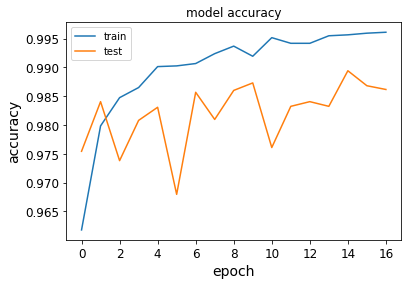

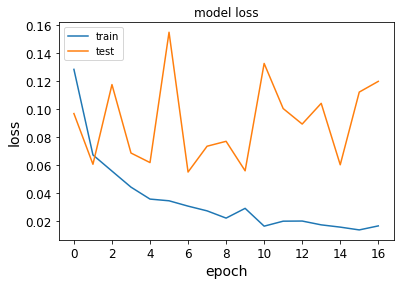

In [56]:
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [57]:
loss,accuracy=model.evaluate(X_test_A,y_test_A)

161/161 [==============================] - 0s 2ms/step - loss: 0.0402 - accuracy: 0.9920


In [58]:
print("Keras Tuner Model Loss: ",loss)
print("Keras Tuner Model Accuracy: ",accuracy)

Keras Tuner Model Loss:  0.04017774760723114
Keras Tuner Model Accuracy:  0.9920217990875244


Keras Tuner model perfrom better than the original model

In [59]:
r = evaluation.shape[0]
evaluation.loc[r] = ['Keras Tuner Model',loss,accuracy,len(history.history['loss'])]
evaluation

,Model,Loss,Accuracy,Epochs
0,Basic Model,0.034804,0.993578,15.0
1,Cross Validation Model,0.034804,0.993578,0.0
2,Keras Tuner Model,0.040178,0.992022,17.0


# Batch Normalization

I added a BN layer after every Dense layer (before the activation function), except for the output layer. I also added a BN layer before the first hidden layer.

In [60]:
model=keras.models.Sequential()
model.add(keras.layers.Flatten(input_shape=[28,28]))
model.add(keras.layers.BatchNormalization())
for _ in range(best_hps.get("hidden")):
    model.add(keras.layers.Dense(best_hps.get("units"),activation='elu',kernel_initializer='he_normal'))
    model.add(keras.layers.BatchNormalization())
model.add(keras.layers.Dense(5,activation='softmax'))

optimizer=keras.optimizers.Adam(learning_rate=best_hps.get("learning_rate"))
model.compile(loss='sparse_categorical_crossentropy',
              optimizer=optimizer,
              metrics=['accuracy'])


early_stopping=keras.callbacks.EarlyStopping(patience=10)
checkpoint_cb=keras.callbacks.ModelCheckpoint('model_digit0To4BN',save_best_only=True)
tensorboard_cv=keras.callbacks.TensorBoard(get_run_logdir())

2023-01-11 12:52:52.933289: I tensorflow/core/profiler/lib/profiler_session.cc:136] Profiler session initializing.
2023-01-11 12:52:52.933340: I tensorflow/core/profiler/lib/profiler_session.cc:155] Profiler session started.
2023-01-11 12:52:53.137008: I tensorflow/core/profiler/lib/profiler_session.cc:172] Profiler session tear down.
2023-01-11 12:52:53.137526: I tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1487] CUPTI activity buffer flushed


In [61]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_1 (Flatten)          (None, 784)               0         
_________________________________________________________________
batch_normalization (BatchNo (None, 784)               3136      
_________________________________________________________________
dense_5 (Dense)              (None, 288)               226080    
_________________________________________________________________
batch_normalization_1 (Batch (None, 288)               1152      
_________________________________________________________________
dense_6 (Dense)              (None, 288)               83232     
_________________________________________________________________
batch_normalization_2 (Batch (None, 288)               1152      
_________________________________________________________________
dense_7 (Dense)              (None, 288)              

In [62]:
history=model.fit(X_train_A,y_train_A,
                  epochs=100,
                  validation_data=(X_valid_A,y_valid_A),
                  callbacks=[checkpoint_cb,early_stopping,tensorboard_cv])

Epoch 1/100
  2/765 [..............................] - ETA: 2:58 - loss: 1.8144 - accuracy: 0.2812 

2023-01-11 12:53:18.447156: I tensorflow/core/profiler/lib/profiler_session.cc:136] Profiler session initializing.
2023-01-11 12:53:18.447198: I tensorflow/core/profiler/lib/profiler_session.cc:155] Profiler session started.


 35/765 [>.............................] - ETA: 14s - loss: 0.6126 - accuracy: 0.7644

2023-01-11 12:53:18.714613: I tensorflow/core/profiler/lib/profiler_session.cc:71] Profiler session collecting data.
2023-01-11 12:53:18.715135: I tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1487] CUPTI activity buffer flushed
2023-01-11 12:53:18.860326: I tensorflow/core/profiler/internal/gpu/cupti_collector.cc:228]  GpuTracer has collected 298 callback api events and 286 activity events. 
2023-01-11 12:53:18.871592: I tensorflow/core/profiler/lib/profiler_session.cc:172] Profiler session tear down.
2023-01-11 12:53:18.884231: I tensorflow/core/profiler/rpc/client/save_profile.cc:137] Creating directory: ./my_logs/run_2023_01_11-12_52_52/train/plugins/profile/2023_01_11_12_53_18
2023-01-11 12:53:18.892475: I tensorflow/core/profiler/rpc/client/save_profile.cc:143] Dumped gzipped tool data for trace.json.gz to ./my_logs/run_2023_01_11-12_52_52/train/plugins/profile/2023_01_11_12_53_18/c9ea16180903.trace.json.gz
2023-01-11 12:53:18.907203: I tensorflow/core/profiler/rpc/client

765/765 [==============================] - 6s 7ms/step - loss: 0.2026 - accuracy: 0.9330 - val_loss: 0.0674 - val_accuracy: 0.9803
Epoch 2/100
765/765 [==============================] - 4s 5ms/step - loss: 0.0598 - accuracy: 0.9802 - val_loss: 0.0692 - val_accuracy: 0.9808
Epoch 3/100
765/765 [==============================] - 5s 6ms/step - loss: 0.0653 - accuracy: 0.9766 - val_loss: 0.0578 - val_accuracy: 0.9847
Epoch 4/100
765/765 [==============================] - 4s 5ms/step - loss: 0.0345 - accuracy: 0.9899 - val_loss: 0.0569 - val_accuracy: 0.9863
Epoch 5/100
765/765 [==============================] - 4s 5ms/step - loss: 0.0398 - accuracy: 0.9881 - val_loss: 0.0528 - val_accuracy: 0.9855
Epoch 6/100
765/765 [==============================] - 4s 6ms/step - loss: 0.0335 - accuracy: 0.9901 - val_loss: 0.0558 - val_accuracy: 0.9862
Epoch 7/100
765/765 [==============================] - 4s 5ms/step - loss: 0.0337 - accuracy: 0.9890 - val_loss: 0.0731 - val_accuracy: 0.9819
Epoch 8/100

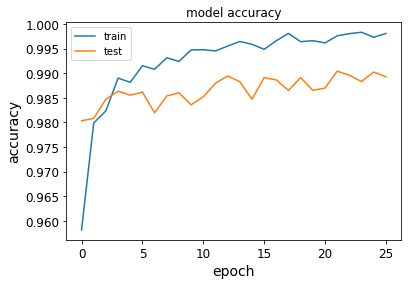

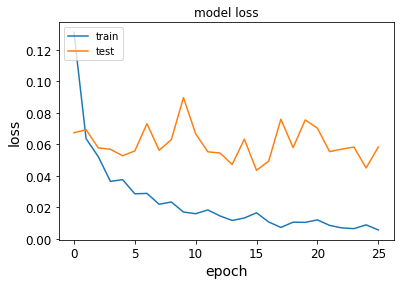

In [63]:
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [64]:
loss,accuracy=model.evaluate(X_test_A,y_test_A)

161/161 [==============================] - 0s 2ms/step - loss: 0.0426 - accuracy: 0.9907


In [65]:
print("Loss: ",loss)
print("Accuracy: ",accuracy)

Loss:  0.04260221868753433
Accuracy:  0.9906596541404724


In [66]:
r = evaluation.shape[0]
evaluation.loc[r] = ['Keras Tuner BatchNormalization Model',loss,accuracy,len(history.history['loss'])]
evaluation

,Model,Loss,Accuracy,Epochs
0,Basic Model,0.034804,0.993578,15.0
1,Cross Validation Model,0.034804,0.993578,0.0
2,Keras Tuner Model,0.040178,0.992022,17.0
3,Keras Tuner BatchNormalization Model,0.042602,0.990660,26.0


In [67]:
model.save('model0To4BN')

The model convergence faster and the model less overfit</br></br>
BatchNorm impacts network training in a fundamental way: it makes the landscape of the corresponding optimization problem be significantly more smooth. This ensures, in particular, that the gradients are more predictive and thus allow for use of larger range of learning rates and faster network convergence.

# Dropout

Since the model is overfitting let dropout to every layer

In [68]:
model=keras.models.Sequential()
model.add(keras.layers.Flatten(input_shape=[28,28]))
model.add(keras.layers.BatchNormalization())
for _ in range(best_hps.get("hidden")):
    model.add(keras.layers.Dense(best_hps.get("units"),activation='elu',kernel_initializer='he_normal'))
    model.add(keras.layers.BatchNormalization())
    model.add(keras.layers.Dropout(rate=0.2))
model.add(keras.layers.Dense(5,activation='softmax'))

optimizer=keras.optimizers.Adam(learning_rate=best_hps.get("learning_rate"))
model.compile(loss='sparse_categorical_crossentropy',
              optimizer=optimizer,
              metrics=['accuracy'])


early_stopping=keras.callbacks.EarlyStopping(patience=10)
checkpoint_cb=keras.callbacks.ModelCheckpoint('model_digit0To4BNDropout',save_best_only=True)
tensorboard_cv=keras.callbacks.TensorBoard(get_run_logdir())

2023-01-11 12:57:29.071676: I tensorflow/core/profiler/lib/profiler_session.cc:136] Profiler session initializing.
2023-01-11 12:57:29.071728: I tensorflow/core/profiler/lib/profiler_session.cc:155] Profiler session started.
2023-01-11 12:57:29.280360: I tensorflow/core/profiler/lib/profiler_session.cc:172] Profiler session tear down.
2023-01-11 12:57:29.280507: I tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1487] CUPTI activity buffer flushed


In [69]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_2 (Flatten)          (None, 784)               0         
_________________________________________________________________
batch_normalization_5 (Batch (None, 784)               3136      
_________________________________________________________________
dense_10 (Dense)             (None, 288)               226080    
_________________________________________________________________
batch_normalization_6 (Batch (None, 288)               1152      
_________________________________________________________________
dropout (Dropout)            (None, 288)               0         
_________________________________________________________________
dense_11 (Dense)             (None, 288)               83232     
_________________________________________________________________
batch_normalization_7 (Batch (None, 288)              

In [70]:
history=model.fit(X_train_A,y_train_A,
                  epochs=100,
                  validation_data=(X_valid_A,y_valid_A),
                  callbacks=[checkpoint_cb,early_stopping,tensorboard_cv])

Epoch 1/100
  2/765 [..............................] - ETA: 3:01 - loss: 2.2647 - accuracy: 0.2734 

2023-01-11 12:57:56.875088: I tensorflow/core/profiler/lib/profiler_session.cc:136] Profiler session initializing.
2023-01-11 12:57:56.875156: I tensorflow/core/profiler/lib/profiler_session.cc:155] Profiler session started.


 31/765 [>.............................] - ETA: 16s - loss: 0.9714 - accuracy: 0.6806

2023-01-11 12:57:57.150896: I tensorflow/core/profiler/lib/profiler_session.cc:71] Profiler session collecting data.
2023-01-11 12:57:57.151319: I tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1487] CUPTI activity buffer flushed
2023-01-11 12:57:57.298783: I tensorflow/core/profiler/internal/gpu/cupti_collector.cc:228]  GpuTracer has collected 326 callback api events and 314 activity events. 
2023-01-11 12:57:57.310910: I tensorflow/core/profiler/lib/profiler_session.cc:172] Profiler session tear down.
2023-01-11 12:57:57.324454: I tensorflow/core/profiler/rpc/client/save_profile.cc:137] Creating directory: ./my_logs/run_2023_01_11-12_57_29/train/plugins/profile/2023_01_11_12_57_57
2023-01-11 12:57:57.333418: I tensorflow/core/profiler/rpc/client/save_profile.cc:143] Dumped gzipped tool data for trace.json.gz to ./my_logs/run_2023_01_11-12_57_29/train/plugins/profile/2023_01_11_12_57_57/c9ea16180903.trace.json.gz
2023-01-11 12:57:57.350347: I tensorflow/core/profiler/rpc/client

765/765 [==============================] - 6s 6ms/step - loss: 0.2759 - accuracy: 0.9127 - val_loss: 0.0721 - val_accuracy: 0.9788
Epoch 2/100
765/765 [==============================] - 5s 6ms/step - loss: 0.0878 - accuracy: 0.9735 - val_loss: 0.0691 - val_accuracy: 0.9800
Epoch 3/100
765/765 [==============================] - 4s 6ms/step - loss: 0.0862 - accuracy: 0.9728 - val_loss: 0.0626 - val_accuracy: 0.9800
Epoch 4/100
765/765 [==============================] - 4s 6ms/step - loss: 0.0551 - accuracy: 0.9830 - val_loss: 0.0548 - val_accuracy: 0.9837
Epoch 5/100
765/765 [==============================] - 5s 6ms/step - loss: 0.0520 - accuracy: 0.9824 - val_loss: 0.0596 - val_accuracy: 0.9844
Epoch 6/100
765/765 [==============================] - 4s 6ms/step - loss: 0.0437 - accuracy: 0.9863 - val_loss: 0.0496 - val_accuracy: 0.9860
Epoch 7/100
765/765 [==============================] - 5s 6ms/step - loss: 0.0461 - accuracy: 0.9847 - val_loss: 0.0449 - val_accuracy: 0.9868
Epoch 8/100

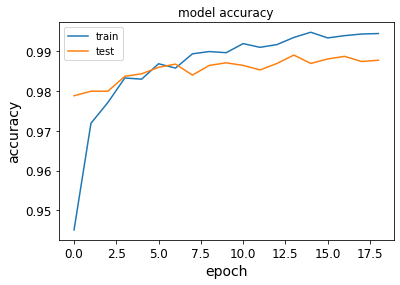

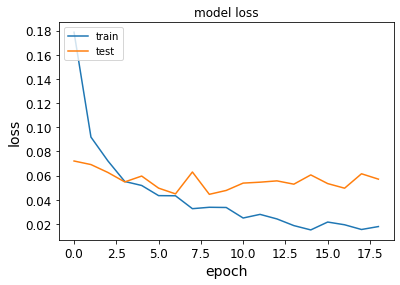

In [71]:
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [72]:
loss,accuracy=model.evaluate(X_test_A,y_test_A)

161/161 [==============================] - 0s 2ms/step - loss: 0.0532 - accuracy: 0.9899


In [73]:
print("Loss: ",loss)
print("Accuracy: ",accuracy)

Loss:  0.05318303033709526
Accuracy:  0.9898812770843506


In [74]:
r = evaluation.shape[0]
evaluation.loc[r] = ['Keras Tuner BatchNormalization Dropout Model',loss,accuracy,len(history.history['loss'])]
evaluation

,Model,Loss,Accuracy,Epochs
0,Basic Model,0.034804,0.993578,15.0
1,Cross Validation Model,0.034804,0.993578,0.0
2,Keras Tuner Model,0.040178,0.992022,17.0
3,Keras Tuner BatchNormalization Model,0.042602,0.990660,26.0
4,Keras Tuner BatchNormalization Dropout Model,0.053183,0.989881,19.0


In [75]:
model.save('model0To4BNDropout')

Model is less overfitting than the original model and the accuracy also very high

# Transfer Learning

Create a new DNN that reuses all the pretrained hidden layers of the previous
model, freezes them, and replaces the softmax output layer with a new one.


Separate dataset B to 100 images per digit

In [76]:
def sample_n_instances_per_class(X,y,n=100):
    Xs,ys=[],[]
    for label in np.unique(y):
        idx=(y==label)
        Xc=X[idx][:n]
        yc=y[idx][:n]
        Xs.append(Xc)
        ys.append(yc)
    return np.concatenate(Xs),np.concatenate(ys)

In [77]:
X_train_B100,y_train_B100=sample_n_instances_per_class(X_train_B,y_train_B,n=100)
X_valid_B100,y_valid_B100=sample_n_instances_per_class(X_valid_B,y_valid_B,100)

Load the pretrained model

In [78]:
model_A=keras.models.load_model('model0To4BNDropout')

In [79]:
model_A.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_2 (Flatten)          (None, 784)               0         
_________________________________________________________________
batch_normalization_5 (Batch (None, 784)               3136      
_________________________________________________________________
dense_10 (Dense)             (None, 288)               226080    
_________________________________________________________________
batch_normalization_6 (Batch (None, 288)               1152      
_________________________________________________________________
dropout (Dropout)            (None, 288)               0         
_________________________________________________________________
dense_11 (Dense)             (None, 288)               83232     
_________________________________________________________________
batch_normalization_7 (Batch (None, 288)              

Note that model_B_on_A and model_A actually share layers now, so when we train one, it will update both models. If we want to avoid that, we need to build model_B_on_A on top of a clone of model_A:

In [80]:
model_A_clone=keras.models.clone_model(model_A)
model_A_clone.set_weights(model_A.get_weights())
model_B_on_A=keras.models.Sequential(model_A_clone.layers[:-1])
model_B_on_A.add(keras.layers.Dense(10,activation='softmax'))

In [81]:
model_A_clone=keras.models.clone_model(model_A)
model_A_clone.set_weights(model_A.get_weights())
model_B_on_A=keras.models.Sequential(model_A_clone.layers[:-1])
model_B_on_A.add(keras.layers.Dense(5,activation='softmax'))

In [82]:
optimizer=keras.optimizers.Adam(learning_rate=1e-3)

for layer in model_B_on_A.layers[:-1]:
    layer.trainable=False
model_B_on_A.compile(
    loss="sparse_categorical_crossentropy",
                     optimizer=keras.optimizers.Adam(learning_rate=1e-3),
                     metrics=["accuracy"])

In [83]:
model_B_on_A.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_2 (Flatten)          (None, 784)               0         
_________________________________________________________________
batch_normalization_5 (Batch (None, 784)               3136      
_________________________________________________________________
dense_10 (Dense)             (None, 288)               226080    
_________________________________________________________________
batch_normalization_6 (Batch (None, 288)               1152      
_________________________________________________________________
dropout (Dropout)            (None, 288)               0         
_________________________________________________________________
dense_11 (Dense)             (None, 288)               83232     
_________________________________________________________________
batch_normalization_7 (Batch (None, 288)              

In [84]:
early_stopping=keras.callbacks.EarlyStopping(patience=10)
checkpoint_cb=keras.callbacks.ModelCheckpoint('model_digit5To9TransferLearning',save_best_only=True)
tensorboard_cv=keras.callbacks.TensorBoard(get_run_logdir())

history=model_B_on_A.fit(X_train_B,y_train_B,
                  epochs=100,
                  validation_data=(X_valid_B,y_valid_B),
                  callbacks=[checkpoint_cb,early_stopping,tensorboard_cv])

2023-01-11 13:04:22.268474: I tensorflow/core/profiler/lib/profiler_session.cc:136] Profiler session initializing.
2023-01-11 13:04:22.268525: I tensorflow/core/profiler/lib/profiler_session.cc:155] Profiler session started.
2023-01-11 13:04:22.463431: I tensorflow/core/profiler/lib/profiler_session.cc:172] Profiler session tear down.
2023-01-11 13:04:22.463576: I tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1487] CUPTI activity buffer flushed


Epoch 1/100
  2/736 [..............................] - ETA: 2:37 - loss: nan - accuracy: 0.0000e+00

2023-01-11 13:04:23.286920: I tensorflow/core/profiler/lib/profiler_session.cc:136] Profiler session initializing.
2023-01-11 13:04:23.286966: I tensorflow/core/profiler/lib/profiler_session.cc:155] Profiler session started.


 59/736 [=>............................] - ETA: 6s - loss: nan - accuracy: 0.0000e+00

2023-01-11 13:04:23.524961: I tensorflow/core/profiler/lib/profiler_session.cc:71] Profiler session collecting data.
2023-01-11 13:04:23.525237: I tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1487] CUPTI activity buffer flushed
2023-01-11 13:04:23.667134: I tensorflow/core/profiler/internal/gpu/cupti_collector.cc:228]  GpuTracer has collected 136 callback api events and 124 activity events. 
2023-01-11 13:04:23.672959: I tensorflow/core/profiler/lib/profiler_session.cc:172] Profiler session tear down.
2023-01-11 13:04:23.678738: I tensorflow/core/profiler/rpc/client/save_profile.cc:137] Creating directory: ./my_logs/run_2023_01_11-13_04_22/train/plugins/profile/2023_01_11_13_04_23
2023-01-11 13:04:23.682728: I tensorflow/core/profiler/rpc/client/save_profile.cc:143] Dumped gzipped tool data for trace.json.gz to ./my_logs/run_2023_01_11-13_04_22/train/plugins/profile/2023_01_11_13_04_23/c9ea16180903.trace.json.gz
2023-01-11 13:04:23.688699: I tensorflow/core/profiler/rpc/client

736/736 [==============================] - 3s 4ms/step - loss: nan - accuracy: 0.0000e+00 - val_loss: nan - val_accuracy: 0.0000e+00
Epoch 2/100
736/736 [==============================] - 2s 3ms/step - loss: nan - accuracy: 0.0000e+00 - val_loss: nan - val_accuracy: 0.0000e+00
Epoch 3/100
736/736 [==============================] - 2s 3ms/step - loss: nan - accuracy: 0.0000e+00 - val_loss: nan - val_accuracy: 0.0000e+00
Epoch 4/100
736/736 [==============================] - 2s 3ms/step - loss: nan - accuracy: 0.0000e+00 - val_loss: nan - val_accuracy: 0.0000e+00
Epoch 5/100
736/736 [==============================] - 3s 3ms/step - loss: nan - accuracy: 0.0000e+00 - val_loss: nan - val_accuracy: 0.0000e+00
Epoch 6/100
736/736 [==============================] - 2s 3ms/step - loss: nan - accuracy: 0.0000e+00 - val_loss: nan - val_accuracy: 0.0000e+00
Epoch 7/100
736/736 [==============================] - 2s 3ms/step - loss: nan - accuracy: 0.0000e+00 - val_loss: nan - val_accuracy: 0.0000e+

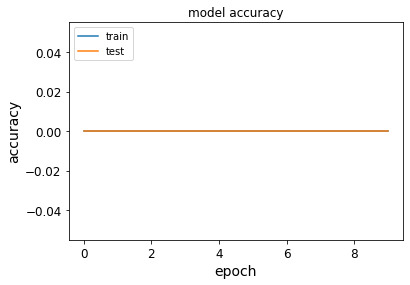

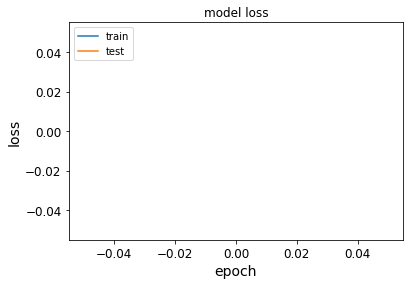

In [85]:
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [86]:
loss,accuracy=model_B_on_A.evaluate(X_test_B,y_test_B)

152/152 [==============================] - 0s 3ms/step - loss: nan - accuracy: 0.0000e+00


In [87]:
print("Loss: ",loss)
print("Accuracy: ",accuracy)

Loss:  nan
Accuracy:  0.0


In [88]:
model.save('mode5To9TranferLearning')

This result show that even we use the model we trained on another dataset but also give a result on the similar dataset